In [4]:
pip install prophet

                                              0.0/13.3 MB ? eta -:--:--
                                              0.2/13.3 MB 6.9 MB/s eta 0:00:02
     -                                        0.6/13.3 MB 6.2 MB/s eta 0:00:03
     -                                        0.6/13.3 MB 6.4 MB/s eta 0:00:02
     ---                                      1.1/13.3 MB 7.3 MB/s eta 0:00:02
     -----                                    1.9/13.3 MB 9.8 MB/s eta 0:00:02
     -------                                  2.5/13.3 MB 9.5 MB/s eta 0:00:02
     ---------                                3.0/13.3 MB 10.1 MB/s eta 0:00:02
     ----------                               3.6/13.3 MB 10.4 MB/s eta 0:00:01
     -----------                              3.9/13.3 MB 10.0 MB/s eta 0:00:01
     -------------                            4.3/13.3 MB 9.9 MB/s eta 0:00:01
     -------------                            4.4/13.3 MB 9.3 MB/s eta 0:00:01
     -------------                            4.4/13.3 M

In [47]:
#library required
import psycopg2

from sqlalchemy import create_engine
from sqlalchemy import text
import os
import time 
from datetime import datetime
import io 
import sys

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np



from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error


In [53]:
#Load the data

# Define the file path
file_path = r"C:\Users\Poovesh Kumar M\Downloads\Planning\1_Data\2_Sep_02_09_2024\majestic pure_Amazon_com_weekly_data.csv"

# Read the CSV file into a DataFrame
df_base = pd.read_csv(file_path)

# Display the DataFrame
print(df_base)



      velocity_bucket        asin Week_Start_date Week_End_date  \
0                1_SF  B00PMR3QF2      2022-09-26    2022-10-02   
1                1_SF  B00PMR3QF2      2022-10-03    2022-10-09   
2                1_SF  B00PMR3QF2      2022-10-10    2022-10-16   
3                1_SF  B00PMR3QF2      2022-10-17    2022-10-23   
4                1_SF  B00PMR3QF2      2022-10-24    2022-10-30   
...               ...         ...             ...           ...   
29805            4_SM  B0D8HVYNM8      2024-07-29    2024-08-04   
29806            4_SM  B0D8HVYNM8      2024-08-05    2024-08-11   
29807            4_SM  B0D8HVYNM8      2024-08-12    2024-08-18   
29808            4_SM  B0D8HVYNM8      2024-08-19    2024-08-25   
29809            4_SM  B0D8HVYNM8      2024-08-26    2024-09-01   

       organic_gmv_units  inorganic_gmv_units   asp_week   ad_spend  \
0               220.8734             145.9917  18.886359  1626.1800   
1               756.0293             464.0168  18.895

In [54]:
df_weekly = df_base

# Convert 'Week_Start_date' to datetime format
df_weekly['Week_Start_date'] = pd.to_datetime(df_weekly['Week_Start_date'])

# Replace NaN values in 'asp_week' column with 0
df_weekly['asp_week'] = df_weekly['asp_week'].fillna(0)


# Define the Outlier Treatment Function 


# Define a function to replace outliers with the previous week's value and track the changes
def replace_outliers_with_previous_week(group, column):
    Q1 = group[column].quantile(0.25)
    Q3 = group[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify outliers
    outliers = (group[column] < lower_bound) | (group[column] > upper_bound)
    
    # Track indices of outliers
    outlier_indices = group.index[outliers].tolist()
    
    # Replace outliers with the previous week's value
    group[column] = np.where(outliers, group[column].shift(1), group[column])
    
    # In case the first value is an outlier and has no previous week to reference, we can forward fill
    group[column] = group[column].fillna(method='ffill')
    
    return group, outlier_indices

# Apply the Function for Each 'asin' and Each Target Column
outliers_info = {'asin': [], 'gmv_units': [], 'organic_gmv_units': [], 'inorganic_gmv_units': []}

def apply_outlier_treatment(df, column):
    outliers_list = []
    df_grouped = df.groupby('asin')
    for name, group in df_grouped:
        treated_group, outlier_indices = replace_outliers_with_previous_week(group, column)
        outliers_list.extend(outlier_indices)
        df.update(treated_group)
    
    outliers_info['asin'].extend(df['asin'].loc[outliers_list].values)
    outliers_info[column].extend(outliers_list)

apply_outlier_treatment(df_weekly, 'gmv_units')
apply_outlier_treatment(df_weekly, 'organic_gmv_units')
apply_outlier_treatment(df_weekly, 'inorganic_gmv_units')

# Display the DataFrame after outlier treatment
print("DataFrame after outlier treatment:")
print(df_weekly[['Week_Start_date', 'asin', 'gmv_units', 'organic_gmv_units', 'inorganic_gmv_units']])

# Display the outliers tracked
print("\nOutliers tracked before and after treatment:")
print(outliers_info)


# Define a function to replace outliers using forward fill
def replace_outliers_ffill(group, column):
    Q1 = group[column].quantile(0.25)
    Q3 = group[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify outliers
    outliers = (group[column] < lower_bound) | (group[column] > upper_bound)
    
    # Replace outliers with NaN
    group.loc[outliers, column] = np.nan
    
    # Fill NaN values with the previous week's value
    group[column] = group[column].ffill()
    
    return group

# Apply the function for each 'asin' and each target column
df_weekly = df_weekly.groupby('asin').apply(replace_outliers_ffill, 'gmv_units').reset_index(drop=True)
df_weekly = df_weekly.groupby('asin').apply(replace_outliers_ffill, 'organic_gmv_units').reset_index(drop=True)
df_weekly = df_weekly.groupby('asin').apply(replace_outliers_ffill, 'inorganic_gmv_units').reset_index(drop=True)

# Display the DataFrame after outlier treatment
print("DataFrame after outlier treatment with ffill:")
print(df_weekly[['Week_Start_date', 'asin', 'gmv_units', 'organic_gmv_units', 'inorganic_gmv_units']])


C:\Users\Poovesh Kumar M\AppData\Local\Temp\ipykernel_9972\70521137.py:27: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_weekly = df_weekly.groupby('asin').apply(replace_outliers_with_previous_week, 'gmv_units').reset_index(drop=True)
C:\Users\Poovesh Kumar M\AppData\Local\Temp\ipykernel_9972\70521137.py:28: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil

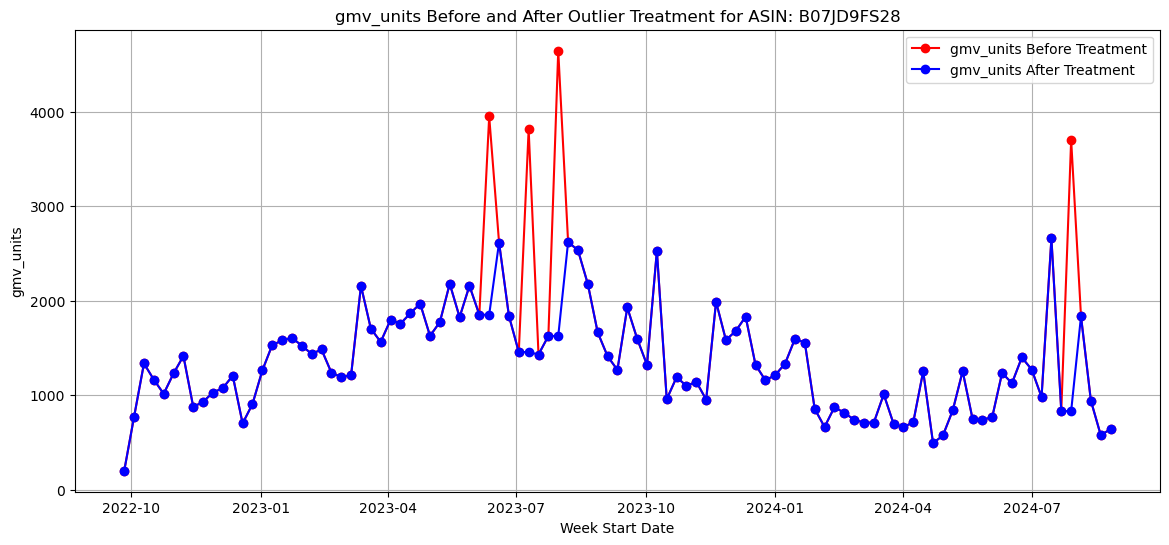

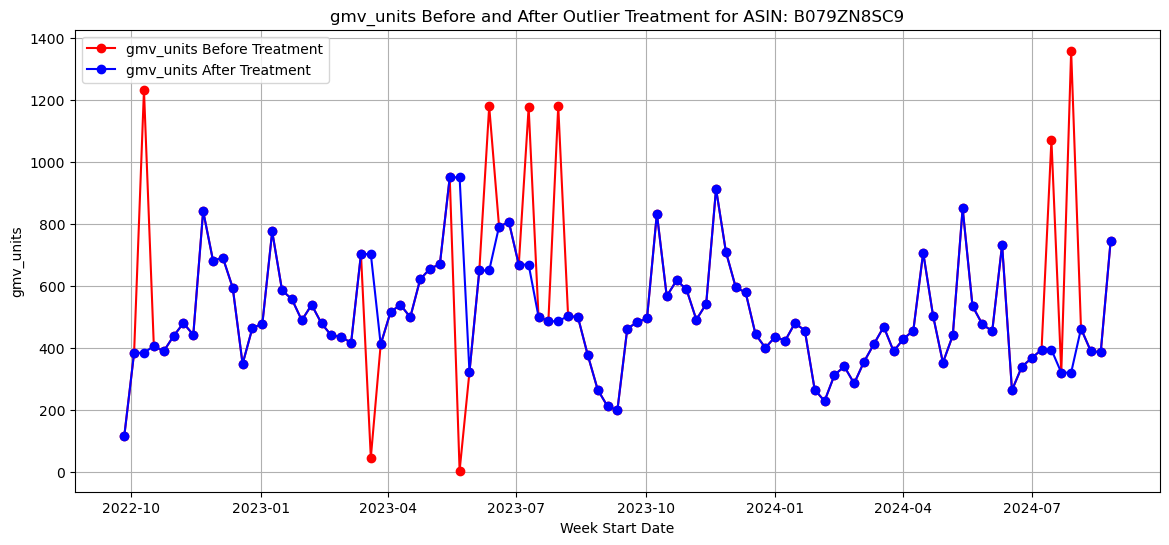

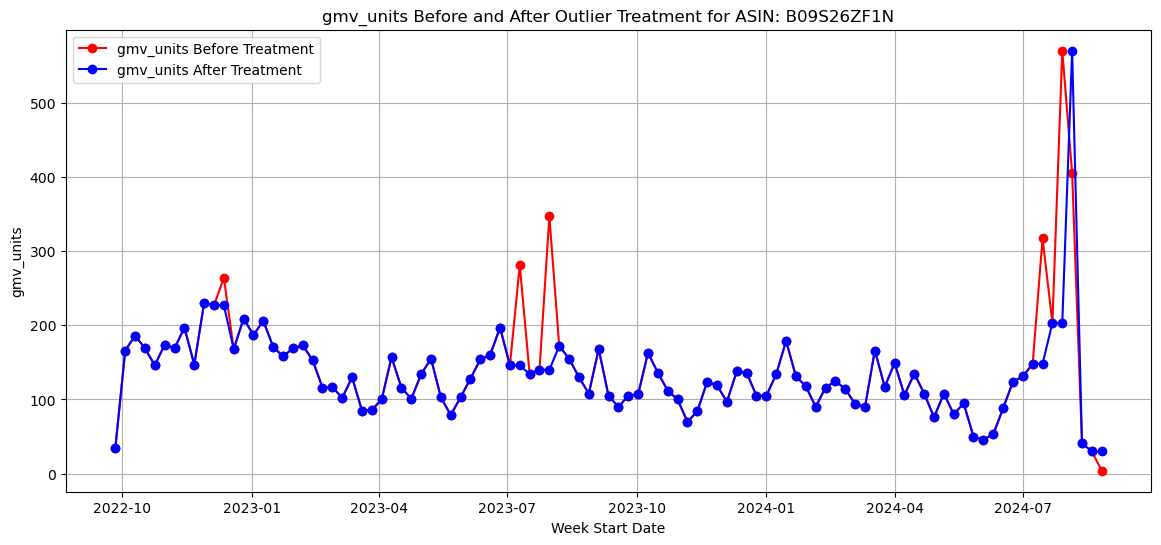

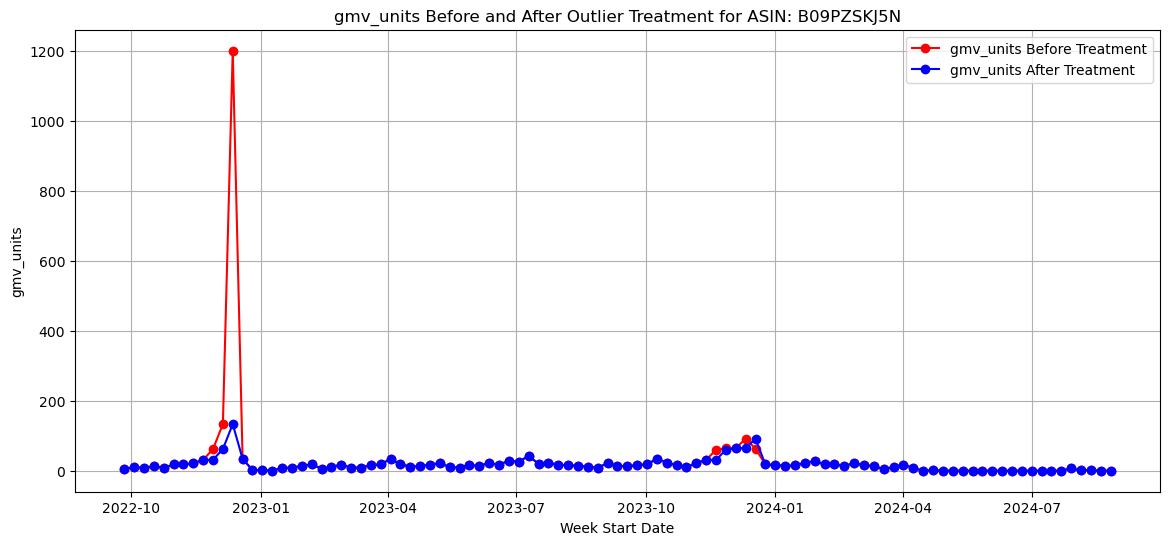

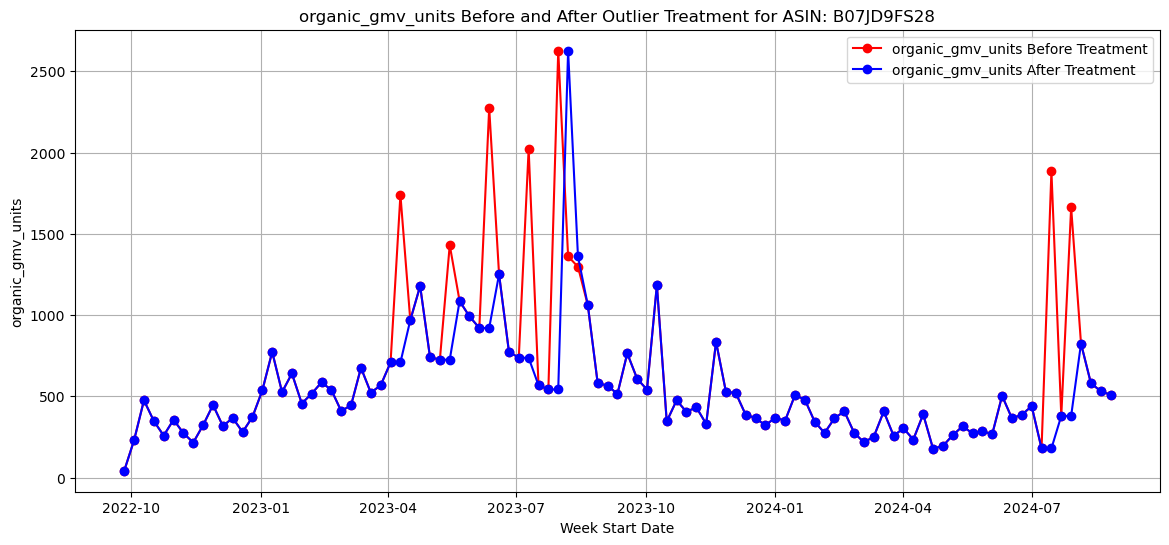

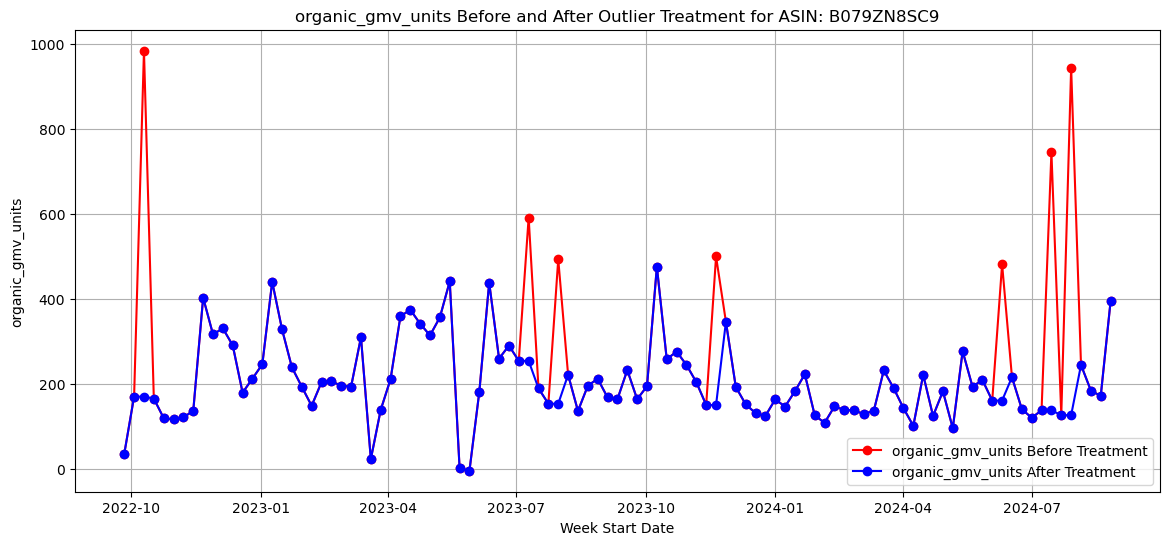

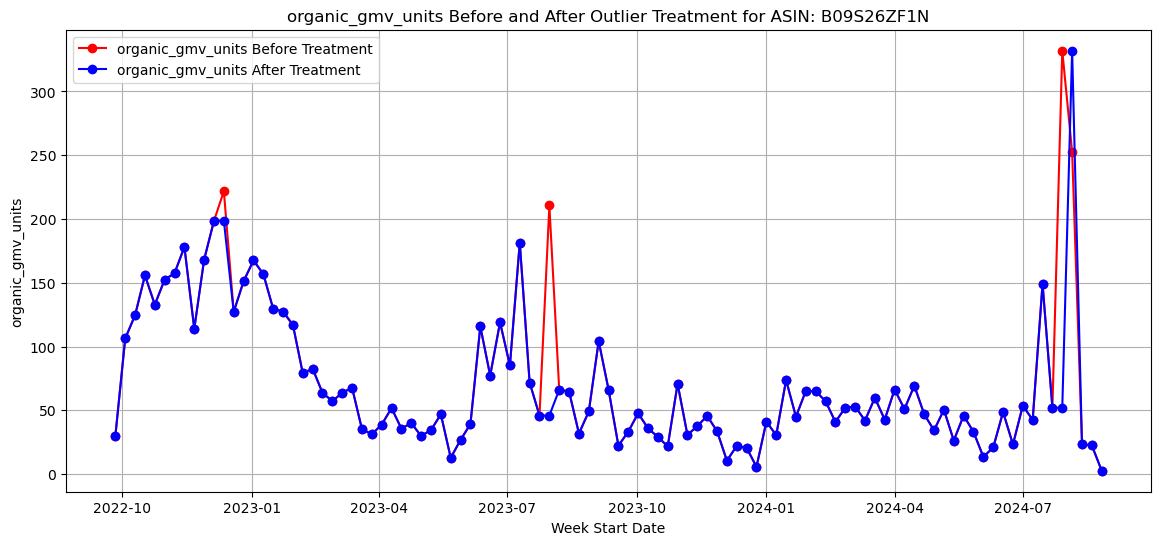

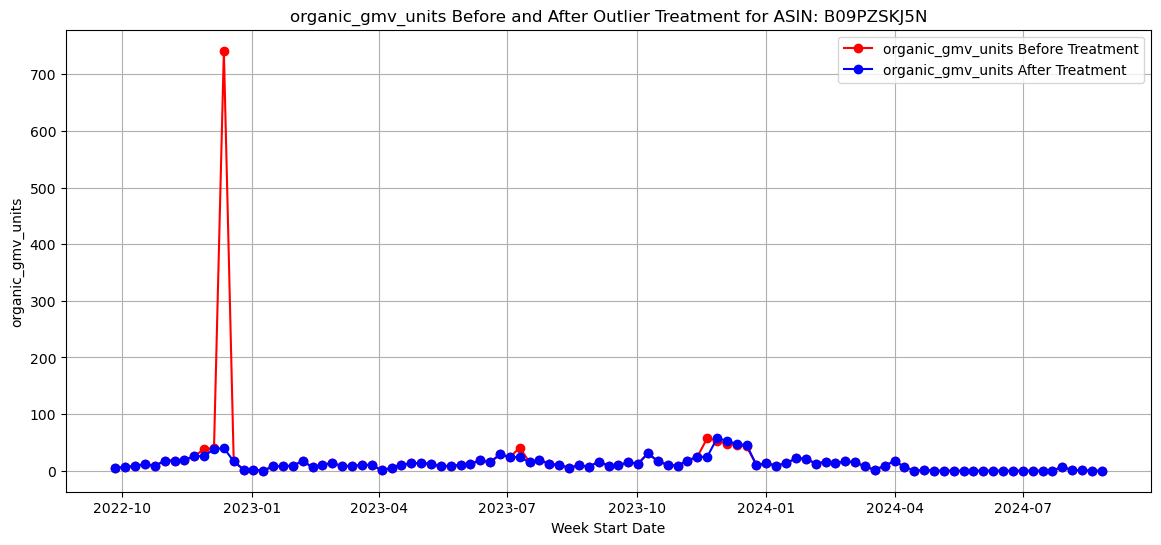

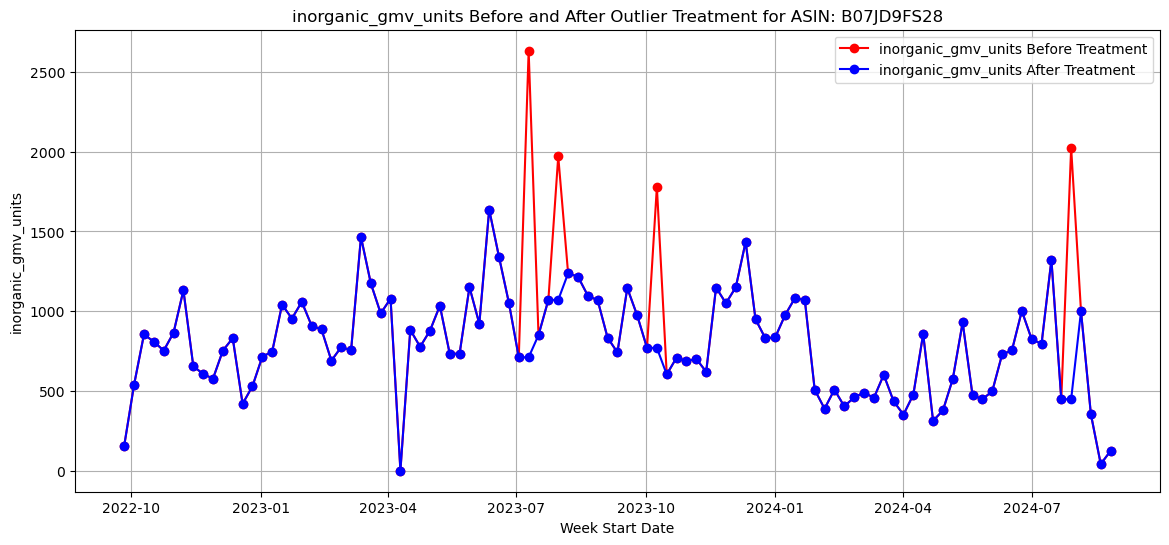

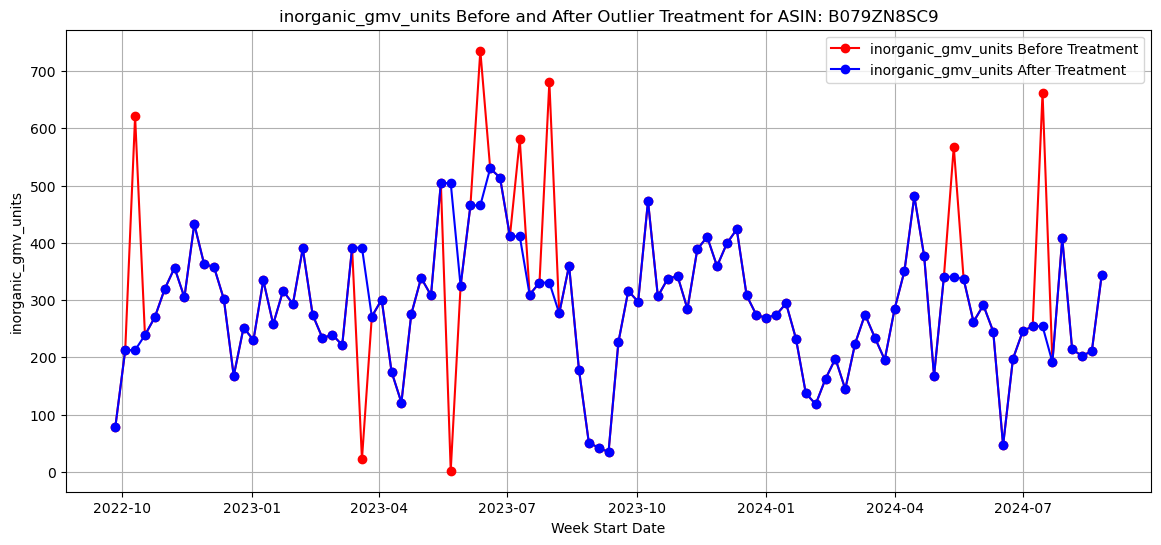

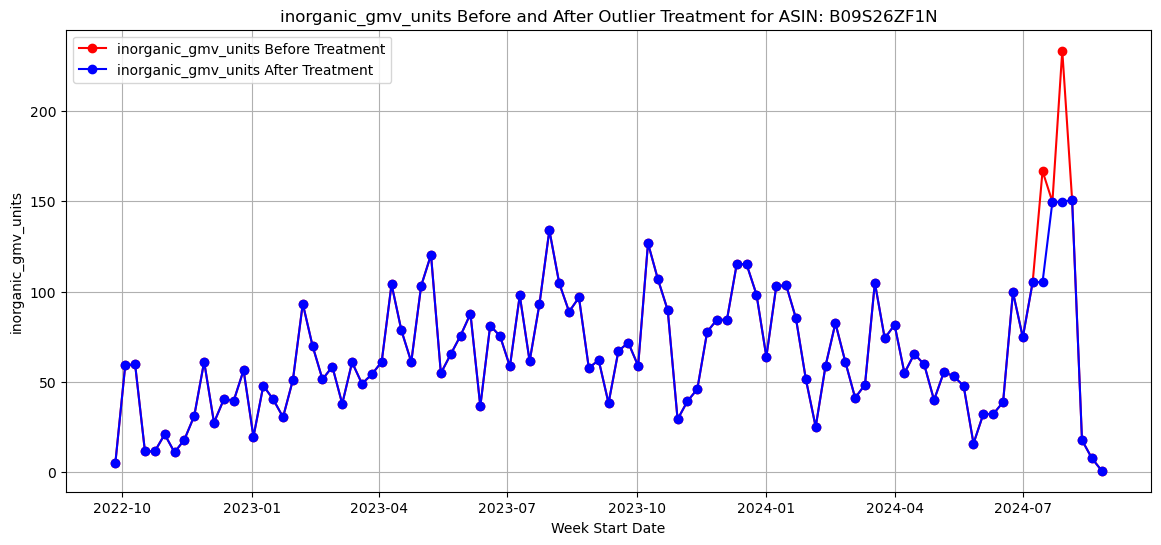

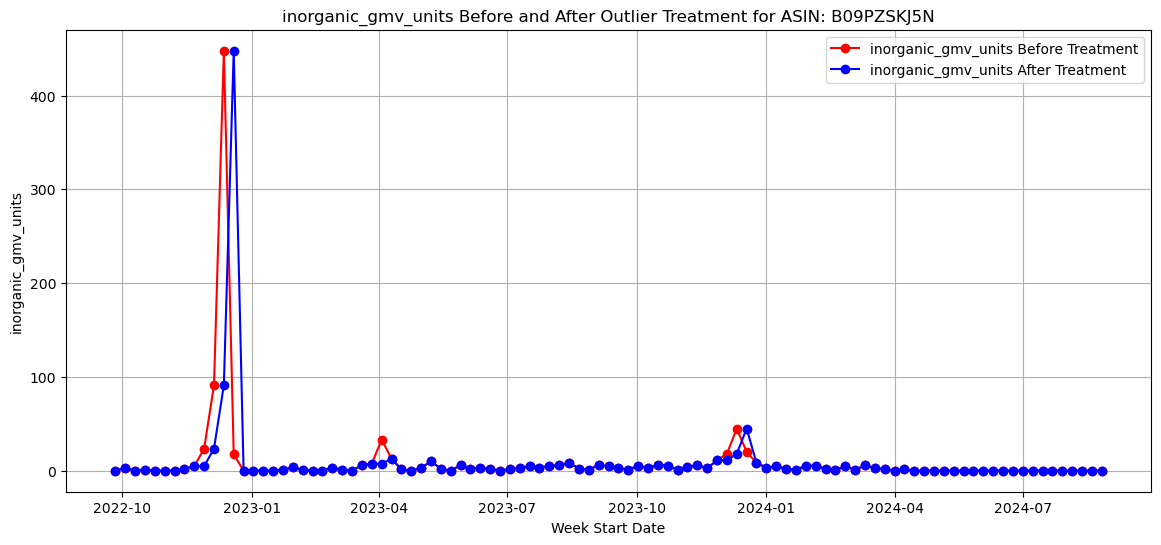

In [55]:
# Define the Outlier Treatment Function 
# Plotting Before and After Outlier Treatment

# Store original DataFrame before treatment
df_weekly_original = df_weekly.copy()

# Define the Outlier Treatment Function
def replace_outliers_with_previous_week(group, column):
    Q1 = group[column].quantile(0.25)
    Q3 = group[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify outliers
    outliers = (group[column] < lower_bound) | (group[column] > upper_bound)
    
    # Replace outliers with the previous week's value
    group[column] = np.where(outliers, group[column].shift(1), group[column])
    
    # In case the first value is an outlier and has no previous week to reference, we can forward fill
    group[column] = group[column].fillna(method='ffill')
    
    return group

# Apply the Outlier Treatment
df_weekly = df_weekly.groupby('asin').apply(replace_outliers_with_previous_week, 'gmv_units').reset_index(drop=True)
df_weekly = df_weekly.groupby('asin').apply(replace_outliers_with_previous_week, 'organic_gmv_units').reset_index(drop=True)
df_weekly = df_weekly.groupby('asin').apply(replace_outliers_with_previous_week, 'inorganic_gmv_units').reset_index(drop=True)

# Plotting Before and After Outlier Treatment
def plot_outlier_treatment(df_before, df_after, column, asin_list):
    for asin in asin_list:
        df_before_asin = df_before[df_before['asin'] == asin]
        df_after_asin = df_after[df_after['asin'] == asin]
        
        plt.figure(figsize=(14, 6))
        plt.plot(df_before_asin['Week_Start_date'], df_before_asin[column], marker='o', color='red', label=f'{column} Before Treatment')
        plt.plot(df_after_asin['Week_Start_date'], df_after_asin[column], marker='o', color='blue', label=f'{column} After Treatment')
        plt.title(f"{column} Before and After Outlier Treatment for ASIN: {asin}")
        plt.xlabel("Week Start Date")
        plt.ylabel(column)
        plt.legend()
        plt.grid(True)
        plt.show()

# Use the actual list of ASINs you want to plot
asin_to_plot = ['B07JD9FS28', 'B079ZN8SC9', 'B09S26ZF1N', 'B09PZSKJ5N']
plot_outlier_treatment(df_weekly_original, df_weekly, 'gmv_units', asin_to_plot)
plot_outlier_treatment(df_weekly_original, df_weekly, 'organic_gmv_units', asin_to_plot)
plot_outlier_treatment(df_weekly_original, df_weekly, 'inorganic_gmv_units', asin_to_plot)


In [56]:
# Split the data into training and testing datasets
train_df = df_weekly[df_weekly['Week_Start_date'] <= '2024-04-29']
test_df = df_weekly[(df_weekly['Week_Start_date'] >= '2024-05-06') & (df_weekly['Week_Start_date'] <= '2024-08-19')]


In [57]:
train_df
test_df

velocity_bucket        asin Week_Start_date Week_End_date  \
84               1_SF  B00PMR3QF2      2024-05-06    2024-05-12   
85               1_SF  B00PMR3QF2      2024-05-13    2024-05-19   
86               1_SF  B00PMR3QF2      2024-05-20    2024-05-26   
87               1_SF  B00PMR3QF2      2024-05-27    2024-06-02   
88               1_SF  B00PMR3QF2      2024-06-03    2024-06-09   
...               ...         ...             ...           ...   
29804            4_SM  B0D8HVYNM8      2024-07-22    2024-07-28   
29805            4_SM  B0D8HVYNM8      2024-07-29    2024-08-04   
29806            4_SM  B0D8HVYNM8      2024-08-05    2024-08-11   
29807            4_SM  B0D8HVYNM8      2024-08-12    2024-08-18   
29808            4_SM  B0D8HVYNM8      2024-08-19    2024-08-25   

       organic_gmv_units  inorganic_gmv_units   asp_week      ad_spend  \
84             2279.6918             944.2419  10.126884  12560.099224   
85              988.9535             775.0357  15.971567   4425.383745   
86              816.4571             272.9077  16.061609   1647.974694   
87              743.9493             480.7210  15.930057   3987.756753   
88              743.9493             480.7210  10.080928   9075.009429   
...                  ...                  ...        ...           ...   
29804             0.0000               0.0000   0.000000      0.000000   
29805             0.0000               0.0000   0.000000      0.000000   
29806             0.0000               0.0000   0.000000      0.000000   
29807             0.0000               0.0000   0.000000      0.000000   
29808             0.0000               0.0000   0.000000      0.000000   

       inventory_Availability%       gmv  inorganic_gmv  organic_gmv  \
84                  116.666667  53388.93       29818.10     23087.56   
85                  116.666667  28333.56       12378.47     15795.19   
86                  100.000000  17667.77        4391.79     13104.90   
87                  100.000000  19625.83        7643.19     11865.61   
88                  100.000000  49729.22       23637.30     25673.50   
...                        ...       ...            ...          ...   
29804               100.000000      0.00           0.00         0.00   
29805               116.666667      0.00           0.00         0.00   
29806               100.000000      0.00           0.00         0.00   
29807               100.000000      0.00           0.00         0.00   
29808               100.000000      0.00           0.00         0.00   

       gmv_units  inventory_available  
84        1951.0               112692  
85        1774.0               108699  
86        1100.0               103875  
87        1232.0               227322  
88        1232.0               240204  
...          ...                  ...  
29804        0.0                 3451  
29805        0.0                 3427  
29806        0.0                 3451  
29807        0.0                 3451  
29808        0.0                 3416  

[4616 rows x 14 columns]

In [58]:
# Ensure 'asin' column exists
print("Columns in train_df:", train_df.columns)
print("Columns in test_df:", test_df.columns)


Columns in train_df: Index(['velocity_bucket', 'asin', 'Week_Start_date', 'Week_End_date',
       'organic_gmv_units', 'inorganic_gmv_units', 'asp_week', 'ad_spend',
       'inventory_Availability%', 'gmv', 'inorganic_gmv', 'organic_gmv',
       'gmv_units', 'inventory_available'],
      dtype='object')
Columns in test_df: Index(['velocity_bucket', 'asin', 'Week_Start_date', 'Week_End_date',
       'organic_gmv_units', 'inorganic_gmv_units', 'asp_week', 'ad_spend',
       'inventory_Availability%', 'gmv', 'inorganic_gmv', 'organic_gmv',
       'gmv_units', 'inventory_available'],
      dtype='object')


In [59]:
%%time

# Forecasting gmv_units

import pandas as pd
from fbprophet import Prophet

def forecast_gmv_units(asin_data, test_df, asin):
    # Ensure that asin_data has more than 1 non-NaN row
    if asin_data[['Week_Start_date', 'gmv_units', 'asp_week', 'ad_spend']].dropna().shape[0] < 2:
        print(f"Insufficient data for ASIN {asin}. Skipping forecast.")
        return pd.DataFrame()  # Return empty DataFrame

    asin_data = asin_data[['Week_Start_date', 'gmv_units', 'asp_week', 'ad_spend']]
    asin_data = asin_data.rename(columns={'Week_Start_date': 'ds', 'gmv_units': 'y'})
    
    # Initialize and fit the model
    model = Prophet()
    model.add_regressor('asp_week')
    model.add_regressor('ad_spend')
    
    try:
        model.fit(asin_data)
    except ValueError as e:
        print(f"Error fitting model for ASIN {asin}: {e}")
        return pd.DataFrame()  # Return empty DataFrame
    
    # Create future DataFrame
    future_periods = len(test_df[test_df['asin'] == asin])
    future = model.make_future_dataframe(periods=future_periods, freq='W')
    
    # Get regressor values from test_df based on the same 'asin'
    regressor_data = test_df[test_df['asin'] == asin][['asp_week', 'ad_spend']].reset_index(drop=True)
    
    # Handle the case where the regressor data is shorter than the future DataFrame
    if len(regressor_data) < len(future):
        future = future.iloc[:len(regressor_data)]
        print(f"Warning: Regressor data for ASIN {asin} is shorter than future periods. Adjusting forecast length.")
    
    # Assign regressor values to future DataFrame
    future = future.reset_index(drop=True)
    if len(regressor_data) > 0:
        future['asp_week'] = regressor_data['asp_week'].reindex(future.index, method='ffill').values
        future['ad_spend'] = regressor_data['ad_spend'].reindex(future.index, method='ffill').values
    
    # Ensure no empty future DataFrame is passed to predict
    if future.shape[0] == 0:
        print(f"No future data for ASIN {asin}. Skipping forecast.")
        return pd.DataFrame()  # Return empty DataFrame

    # Generate the forecast
    try:
        forecast = model.predict(future)
    except ValueError as e:
        print(f"Error generating forecast for ASIN {asin}: {e}")
        return pd.DataFrame()  # Return empty DataFrame
    
    return forecast

forecasts_gmv_units = {}
for asin in train_df['asin'].unique():
    asin_data = train_df[train_df['asin'] == asin]
    if asin_data.empty:
        print(f"No data found for ASIN: {asin}")
        continue
    forecast = forecast_gmv_units(asin_data, test_df, asin)
    if not forecast.empty:
        forecasts_gmv_units[asin] = forecast


18:40:47 - cmdstanpy - INFO - Chain [1] start processing
18:40:47 - cmdstanpy - INFO - Chain [1] done processing


18:40:48 - cmdstanpy - INFO - Chain [1] start processing
18:40:48 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B00Q7Z1UZ6. Skipping forecast.


18:40:49 - cmdstanpy - INFO - Chain [1] start processing
18:40:49 - cmdstanpy - INFO - Chain [1] done processing


18:40:49 - cmdstanpy - INFO - Chain [1] start processing
18:40:49 - cmdstanpy - INFO - Chain [1] done processing


18:40:50 - cmdstanpy - INFO - Chain [1] start processing
18:40:50 - cmdstanpy - INFO - Chain [1] done processing


18:40:51 - cmdstanpy - INFO - Chain [1] start processing


No future data for ASIN B00QR7T8WQ. Skipping forecast.


18:40:51 - cmdstanpy - INFO - Chain [1] done processing


18:40:51 - cmdstanpy - INFO - Chain [1] start processing
18:40:52 - cmdstanpy - INFO - Chain [1] done processing


18:40:52 - cmdstanpy - INFO - Chain [1] start processing
18:40:52 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B00UA2A0XK. Skipping forecast.


18:40:53 - cmdstanpy - INFO - Chain [1] start processing
18:40:53 - cmdstanpy - INFO - Chain [1] done processing


18:40:53 - cmdstanpy - INFO - Chain [1] start processing
18:40:54 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B00VXEQ0WO. Skipping forecast.
No future data for ASIN B00VXIV1XI. Skipping forecast.
No future data for ASIN B00WFXNXVI. Skipping forecast.
No future data for ASIN B00WH2CKCA. Skipping forecast.
No future data for ASIN B00WKTKBTY. Skipping forecast.


18:40:56 - cmdstanpy - INFO - Chain [1] start processing
18:40:56 - cmdstanpy - INFO - Chain [1] done processing


18:40:56 - cmdstanpy - INFO - Chain [1] start processing
18:40:57 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B00YQ93VPW. Skipping forecast.
No future data for ASIN B00Z5WJIHO. Skipping forecast.
No future data for ASIN B01057FM6E. Skipping forecast.
No future data for ASIN B0105POI9I. Skipping forecast.
No future data for ASIN B011NSRBY0. Skipping forecast.
No future data for ASIN B012UQJNMC. Skipping forecast.
No future data for ASIN B014JFT9DU. Skipping forecast.
No future data for ASIN B016H8ICBC. Skipping forecast.
No future data for ASIN B016RQ8PRU. Skipping forecast.
No future data for ASIN B01728CU8M. Skipping forecast.


18:41:00 - cmdstanpy - INFO - Chain [1] start processing
18:41:01 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B01745E4C8. Skipping forecast.
No future data for ASIN B01766QDTC. Skipping forecast.


18:41:01 - cmdstanpy - INFO - Chain [1] start processing
18:41:02 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B01768QEPI. Skipping forecast.


18:41:03 - cmdstanpy - INFO - Chain [1] start processing
18:41:03 - cmdstanpy - INFO - Chain [1] done processing


18:41:03 - cmdstanpy - INFO - Chain [1] start processing
18:41:04 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B01771C9H6. Skipping forecast.
No future data for ASIN B0177J3BVG. Skipping forecast.


18:41:04 - cmdstanpy - INFO - Chain [1] start processing
18:41:05 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B017SLT8ME. Skipping forecast.
No future data for ASIN B01BGIB81Y. Skipping forecast.
No future data for ASIN B01BHO79V0. Skipping forecast.


18:41:06 - cmdstanpy - INFO - Chain [1] start processing
18:41:06 - cmdstanpy - INFO - Chain [1] done processing


18:41:06 - cmdstanpy - INFO - Chain [1] start processing
18:41:07 - cmdstanpy - INFO - Chain [1] done processing


18:41:07 - cmdstanpy - INFO - Chain [1] start processing
18:41:07 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B01CHW4QOO. Skipping forecast.
No future data for ASIN B01CKBJQCO. Skipping forecast.
No future data for ASIN B01CO4EPQY. Skipping forecast.
No future data for ASIN B01DV9H7Z2. Skipping forecast.
No future data for ASIN B01DVU2ZQW. Skipping forecast.


18:41:09 - cmdstanpy - INFO - Chain [1] start processing
18:41:09 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B01ERVKA3Y. Skipping forecast.
No future data for ASIN B01FR1PYXE. Skipping forecast.


18:41:10 - cmdstanpy - INFO - Chain [1] start processing
18:41:11 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B01GHF9OXU. Skipping forecast.
No future data for ASIN B01GZ6ZAVG. Skipping forecast.
No future data for ASIN B01HCWXUIC. Skipping forecast.
No future data for ASIN B01HIW5BG0. Skipping forecast.
No future data for ASIN B01HN30YAW. Skipping forecast.
No future data for ASIN B01HSHKNC2. Skipping forecast.


18:41:13 - cmdstanpy - INFO - Chain [1] start processing
18:41:13 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B01IIJI4TS. Skipping forecast.
No future data for ASIN B01INZE248. Skipping forecast.


18:41:14 - cmdstanpy - INFO - Chain [1] start processing
18:41:14 - cmdstanpy - INFO - Chain [1] done processing


18:41:14 - cmdstanpy - INFO - Chain [1] start processing
18:41:15 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B01IU1ZUNM. Skipping forecast.
No future data for ASIN B01JLJGIEC. Skipping forecast.
No future data for ASIN B01JRV494K. Skipping forecast.
No future data for ASIN B01JRW3EJA. Skipping forecast.


18:41:16 - cmdstanpy - INFO - Chain [1] start processing
18:41:16 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B01K86X4HG. Skipping forecast.
No future data for ASIN B01K8IJVWG. Skipping forecast.


18:41:17 - cmdstanpy - INFO - Chain [1] start processing
18:41:17 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B01K8XC1FU. Skipping forecast.
No future data for ASIN B01K90KCP8. Skipping forecast.
No future data for ASIN B01K91YRTO. Skipping forecast.
No future data for ASIN B01K93HIDO. Skipping forecast.
No future data for ASIN B01KFENEXK. Skipping forecast.
No future data for ASIN B01KW4Q6VU. Skipping forecast.
No future data for ASIN B01KYFMHJC. Skipping forecast.
No future data for ASIN B01LAHAQ2I. Skipping forecast.
No future data for ASIN B01LAJP9LE. Skipping forecast.
No future data for ASIN B01LDGNJHK. Skipping forecast.
No future data for ASIN B01LMJQ53I. Skipping forecast.
No future data for ASIN B01LW1N3YN. Skipping forecast.
No future data for ASIN B01LWMTMIW. Skipping forecast.
No future data for ASIN B01LWYNWIF. Skipping forecast.


18:41:21 - cmdstanpy - INFO - Chain [1] start processing
18:41:21 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B01LWYV0F3. Skipping forecast.


18:41:22 - cmdstanpy - INFO - Chain [1] start processing
18:41:22 - cmdstanpy - INFO - Chain [1] done processing


18:41:22 - cmdstanpy - INFO - Chain [1] start processing
18:41:23 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B01LXMPA35. Skipping forecast.
No future data for ASIN B01LXY3G5B. Skipping forecast.
No future data for ASIN B01LY9DCZ9. Skipping forecast.
No future data for ASIN B01LY9FZHH. Skipping forecast.
No future data for ASIN B01LY9GFBF. Skipping forecast.
No future data for ASIN B01LYKQRWH. Skipping forecast.


18:41:25 - cmdstanpy - INFO - Chain [1] start processing


No future data for ASIN B01LYR2KTP. Skipping forecast.


18:41:25 - cmdstanpy - INFO - Chain [1] done processing


18:41:25 - cmdstanpy - INFO - Chain [1] start processing
18:41:26 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B01M12V5G3. Skipping forecast.
No future data for ASIN B01M1CJSZH. Skipping forecast.
No future data for ASIN B01MQYUZ0C. Skipping forecast.
No future data for ASIN B01MSEKDFX. Skipping forecast.
No future data for ASIN B01MU29C2X. Skipping forecast.


18:41:27 - cmdstanpy - INFO - Chain [1] start processing
18:41:27 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B01MY4KYSG. Skipping forecast.
No future data for ASIN B01MYA4Q1X. Skipping forecast.


18:41:28 - cmdstanpy - INFO - Chain [1] start processing
18:41:29 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B01N2W16I8. Skipping forecast.
No future data for ASIN B01N35XMUC. Skipping forecast.
No future data for ASIN B01N3T69R3. Skipping forecast.
No future data for ASIN B01N6IHDIN. Skipping forecast.
No future data for ASIN B01N6N716A. Skipping forecast.
No future data for ASIN B01N7L0WA6. Skipping forecast.
No future data for ASIN B01N7OJUIT. Skipping forecast.


18:41:31 - cmdstanpy - INFO - Chain [1] start processing
18:41:31 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B01N9EI165. Skipping forecast.
No future data for ASIN B01N9TLIJU. Skipping forecast.
No future data for ASIN B06XBSBTMV. Skipping forecast.
No future data for ASIN B06XC5D97Z. Skipping forecast.


18:41:32 - cmdstanpy - INFO - Chain [1] start processing
18:41:32 - cmdstanpy - INFO - Chain [1] done processing


18:41:33 - cmdstanpy - INFO - Chain [1] start processing
18:41:33 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B06Y15C6CS. Skipping forecast.
No future data for ASIN B06ZZXG2CJ. Skipping forecast.
No future data for ASIN B071JCL3XQ. Skipping forecast.
No future data for ASIN B072YVYQVR. Skipping forecast.
No future data for ASIN B073XXQMM9. Skipping forecast.
No future data for ASIN B074WZJDLZ. Skipping forecast.
No future data for ASIN B0753LHJ8X. Skipping forecast.
No future data for ASIN B075DJ88X5. Skipping forecast.


18:41:36 - cmdstanpy - INFO - Chain [1] start processing
18:41:36 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B075MSCQZJ. Skipping forecast.
No future data for ASIN B076YPNBBR. Skipping forecast.


18:41:37 - cmdstanpy - INFO - Chain [1] start processing
18:41:37 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B077GP9C96. Skipping forecast.
No future data for ASIN B077GPTZTS. Skipping forecast.
No future data for ASIN B078SS67K7. Skipping forecast.
No future data for ASIN B078W5K1T1. Skipping forecast.


18:41:39 - cmdstanpy - INFO - Chain [1] start processing
18:41:39 - cmdstanpy - INFO - Chain [1] done processing


18:41:40 - cmdstanpy - INFO - Chain [1] start processing
18:41:40 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B07C39LV4Z. Skipping forecast.
No future data for ASIN B07C5B9C16. Skipping forecast.


18:41:41 - cmdstanpy - INFO - Chain [1] start processing
18:41:41 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B07CP3X2K3. Skipping forecast.
No future data for ASIN B07DJYGCHC. Skipping forecast.
No future data for ASIN B07DPWB7LW. Skipping forecast.
No future data for ASIN B07F7G3PJW. Skipping forecast.


18:41:43 - cmdstanpy - INFO - Chain [1] start processing
18:41:43 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B07G4LZDJH. Skipping forecast.


18:41:45 - cmdstanpy - INFO - Chain [1] start processing
18:41:45 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B07G7LPY5C. Skipping forecast.
No future data for ASIN B07G7LTQ9Q. Skipping forecast.


18:41:46 - cmdstanpy - INFO - Chain [1] start processing
18:41:46 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B07G8J8F3Z. Skipping forecast.
No future data for ASIN B07G8JN3NF. Skipping forecast.
No future data for ASIN B07G8JTRDX. Skipping forecast.
No future data for ASIN B07G8K7VT1. Skipping forecast.
No future data for ASIN B07G8LV6PV. Skipping forecast.


18:41:48 - cmdstanpy - INFO - Chain [1] start processing
18:41:48 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B07G8LY9HB. Skipping forecast.


18:41:49 - cmdstanpy - INFO - Chain [1] start processing
18:41:49 - cmdstanpy - INFO - Chain [1] done processing


18:41:50 - cmdstanpy - INFO - Chain [1] start processing
18:41:50 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B07G8MHVXQ. Skipping forecast.
No future data for ASIN B07G8MK45Z. Skipping forecast.
No future data for ASIN B07G8MPT3N. Skipping forecast.
No future data for ASIN B07G8N5ZP4. Skipping forecast.


18:41:52 - cmdstanpy - INFO - Chain [1] start processing
18:41:52 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B07G8P6NMW. Skipping forecast.


18:41:53 - cmdstanpy - INFO - Chain [1] start processing
18:41:53 - cmdstanpy - INFO - Chain [1] done processing


18:41:53 - cmdstanpy - INFO - Chain [1] start processing
18:41:54 - cmdstanpy - INFO - Chain [1] done processing


18:41:54 - cmdstanpy - INFO - Chain [1] start processing
18:41:54 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B07GJ7P4DQ. Skipping forecast.
No future data for ASIN B07GNZP9P5. Skipping forecast.


18:41:55 - cmdstanpy - INFO - Chain [1] start processing
18:41:56 - cmdstanpy - INFO - Chain [1] done processing


18:41:56 - cmdstanpy - INFO - Chain [1] start processing
18:41:56 - cmdstanpy - INFO - Chain [1] done processing


18:41:56 - cmdstanpy - INFO - Chain [1] start processing
18:41:57 - cmdstanpy - INFO - Chain [1] done processing


18:41:57 - cmdstanpy - INFO - Chain [1] start processing
18:41:57 - cmdstanpy - INFO - Chain [1] done processing


18:41:58 - cmdstanpy - INFO - Chain [1] start processing
18:41:58 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B07GPWVC4F. Skipping forecast.
No future data for ASIN B07GPWX8CF. Skipping forecast.


18:41:59 - cmdstanpy - INFO - Chain [1] start processing
18:41:59 - cmdstanpy - INFO - Chain [1] done processing


18:41:59 - cmdstanpy - INFO - Chain [1] start processing
18:42:00 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B07H8JL7MV. Skipping forecast.
No future data for ASIN B07H8KP1PB. Skipping forecast.


18:42:01 - cmdstanpy - INFO - Chain [1] start processing
18:42:01 - cmdstanpy - INFO - Chain [1] done processing


18:42:01 - cmdstanpy - INFO - Chain [1] start processing
18:42:01 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B07HPFYQLB. Skipping forecast.


18:42:02 - cmdstanpy - INFO - Chain [1] start processing
18:42:02 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B07HQ4YBSS. Skipping forecast.
No future data for ASIN B07HQGK7L4. Skipping forecast.


18:42:03 - cmdstanpy - INFO - Chain [1] start processing
18:42:04 - cmdstanpy - INFO - Chain [1] done processing


18:42:04 - cmdstanpy - INFO - Chain [1] start processing
18:42:04 - cmdstanpy - INFO - Chain [1] done processing


18:42:04 - cmdstanpy - INFO - Chain [1] start processing
18:42:05 - cmdstanpy - INFO - Chain [1] done processing


18:42:05 - cmdstanpy - INFO - Chain [1] start processing
18:42:05 - cmdstanpy - INFO - Chain [1] done processing


18:42:06 - cmdstanpy - INFO - Chain [1] start processing
18:42:06 - cmdstanpy - INFO - Chain [1] done processing


18:42:06 - cmdstanpy - INFO - Chain [1] start processing
18:42:07 - cmdstanpy - INFO - Chain [1] done processing


18:42:07 - cmdstanpy - INFO - Chain [1] start processing
18:42:07 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B07N2GRLKB. Skipping forecast.


18:42:08 - cmdstanpy - INFO - Chain [1] start processing
18:42:08 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B07N2LSXR9. Skipping forecast.


18:42:10 - cmdstanpy - INFO - Chain [1] start processing
18:42:10 - cmdstanpy - INFO - Chain [1] done processing


18:42:10 - cmdstanpy - INFO - Chain [1] start processing
18:42:11 - cmdstanpy - INFO - Chain [1] done processing


18:42:11 - cmdstanpy - INFO - Chain [1] start processing
18:42:11 - cmdstanpy - INFO - Chain [1] done processing


18:42:12 - cmdstanpy - INFO - Chain [1] start processing
18:42:12 - cmdstanpy - INFO - Chain [1] done processing


18:42:13 - cmdstanpy - INFO - Chain [1] start processing
18:42:13 - cmdstanpy - INFO - Chain [1] done processing


18:42:13 - cmdstanpy - INFO - Chain [1] start processing
18:42:14 - cmdstanpy - INFO - Chain [1] done processing


18:42:15 - cmdstanpy - INFO - Chain [1] start processing
18:42:15 - cmdstanpy - INFO - Chain [1] done processing


18:42:15 - cmdstanpy - INFO - Chain [1] start processing
18:42:16 - cmdstanpy - INFO - Chain [1] done processing


18:42:16 - cmdstanpy - INFO - Chain [1] start processing
18:42:17 - cmdstanpy - INFO - Chain [1] done processing


18:42:17 - cmdstanpy - INFO - Chain [1] start processing
18:42:17 - cmdstanpy - INFO - Chain [1] done processing


18:42:18 - cmdstanpy - INFO - Chain [1] start processing
18:42:19 - cmdstanpy - INFO - Chain [1] done processing


18:42:19 - cmdstanpy - INFO - Chain [1] start processing
18:42:19 - cmdstanpy - INFO - Chain [1] done processing


18:42:20 - cmdstanpy - INFO - Chain [1] start processing
18:42:20 - cmdstanpy - INFO - Chain [1] done processing


18:42:21 - cmdstanpy - INFO - Chain [1] start processing
18:42:21 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B07SGCBRZX. Skipping forecast.
No future data for ASIN B07SQHFP52. Skipping forecast.
No future data for ASIN B07TKD35BH. Skipping forecast.
No future data for ASIN B07TKZRNGZ. Skipping forecast.


18:42:22 - cmdstanpy - INFO - Chain [1] start processing
18:42:23 - cmdstanpy - INFO - Chain [1] done processing


18:42:24 - cmdstanpy - INFO - Chain [1] start processing
18:42:24 - cmdstanpy - INFO - Chain [1] done processing


18:42:24 - cmdstanpy - INFO - Chain [1] start processing
18:42:24 - cmdstanpy - INFO - Chain [1] done processing


18:42:25 - cmdstanpy - INFO - Chain [1] start processing
18:42:25 - cmdstanpy - INFO - Chain [1] done processing


18:42:26 - cmdstanpy - INFO - Chain [1] start processing
18:42:26 - cmdstanpy - INFO - Chain [1] done processing


18:42:26 - cmdstanpy - INFO - Chain [1] start processing
18:42:27 - cmdstanpy - INFO - Chain [1] done processing


18:42:27 - cmdstanpy - INFO - Chain [1] start processing
18:42:27 - cmdstanpy - INFO - Chain [1] done processing


18:42:27 - cmdstanpy - INFO - Chain [1] start processing
18:42:28 - cmdstanpy - INFO - Chain [1] done processing


18:42:28 - cmdstanpy - INFO - Chain [1] start processing
18:42:28 - cmdstanpy - INFO - Chain [1] done processing


18:42:29 - cmdstanpy - INFO - Chain [1] start processing
18:42:29 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B082TW3YFH. Skipping forecast.


18:42:29 - cmdstanpy - INFO - Chain [1] start processing
18:42:30 - cmdstanpy - INFO - Chain [1] done processing


18:42:30 - cmdstanpy - INFO - Chain [1] start processing
18:42:31 - cmdstanpy - INFO - Chain [1] done processing


18:42:31 - cmdstanpy - INFO - Chain [1] start processing
18:42:31 - cmdstanpy - INFO - Chain [1] done processing


18:42:32 - cmdstanpy - INFO - Chain [1] start processing
18:42:32 - cmdstanpy - INFO - Chain [1] done processing


18:42:33 - cmdstanpy - INFO - Chain [1] start processing
18:42:33 - cmdstanpy - INFO - Chain [1] done processing


18:42:33 - cmdstanpy - INFO - Chain [1] start processing
18:42:34 - cmdstanpy - INFO - Chain [1] done processing


18:42:34 - cmdstanpy - INFO - Chain [1] start processing
18:42:35 - cmdstanpy - INFO - Chain [1] done processing


18:42:35 - cmdstanpy - INFO - Chain [1] start processing
18:42:36 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B0861DW1YC. Skipping forecast.
No future data for ASIN B08682PYNV. Skipping forecast.
No future data for ASIN B086GFZBKZ. Skipping forecast.


18:42:37 - cmdstanpy - INFO - Chain [1] start processing
18:42:37 - cmdstanpy - INFO - Chain [1] done processing


18:42:37 - cmdstanpy - INFO - Chain [1] start processing
18:42:38 - cmdstanpy - INFO - Chain [1] done processing


18:42:38 - cmdstanpy - INFO - Chain [1] start processing
18:42:38 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B08B89NVSH. Skipping forecast.


18:42:39 - cmdstanpy - INFO - Chain [1] start processing
18:42:40 - cmdstanpy - INFO - Chain [1] done processing


18:42:40 - cmdstanpy - INFO - Chain [1] start processing
18:42:40 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B08BWL3SMY. Skipping forecast.


18:42:41 - cmdstanpy - INFO - Chain [1] start processing
18:42:42 - cmdstanpy - INFO - Chain [1] done processing


18:42:42 - cmdstanpy - INFO - Chain [1] start processing
18:43:03 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B08HBRN53J. Skipping forecast.


18:43:04 - cmdstanpy - INFO - Chain [1] start processing
18:43:04 - cmdstanpy - INFO - Chain [1] done processing


18:43:05 - cmdstanpy - INFO - Chain [1] start processing
18:43:05 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B08K3M16PR. Skipping forecast.


18:43:06 - cmdstanpy - INFO - Chain [1] start processing
18:43:06 - cmdstanpy - INFO - Chain [1] done processing


18:43:07 - cmdstanpy - INFO - Chain [1] start processing
18:43:07 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B08KHYTWKV. Skipping forecast.


18:43:08 - cmdstanpy - INFO - Chain [1] start processing
18:43:08 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B08KWSNPBY. Skipping forecast.
No future data for ASIN B08KXPQ9SJ. Skipping forecast.
No future data for ASIN B08KXQH58T. Skipping forecast.
No future data for ASIN B08KXVJQZV. Skipping forecast.
No future data for ASIN B08KXXVV5T. Skipping forecast.


18:43:12 - cmdstanpy - INFO - Chain [1] start processing
18:43:12 - cmdstanpy - INFO - Chain [1] done processing


18:43:13 - cmdstanpy - INFO - Chain [1] start processing
18:43:13 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B08L3ZZFGB. Skipping forecast.


18:43:13 - cmdstanpy - INFO - Chain [1] start processing
18:43:14 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B08L5LBXTT. Skipping forecast.
No future data for ASIN B08L8G69LG. Skipping forecast.


18:43:15 - cmdstanpy - INFO - Chain [1] start processing
18:43:15 - cmdstanpy - INFO - Chain [1] done processing


18:43:16 - cmdstanpy - INFO - Chain [1] start processing
18:43:16 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B08QXB6H5P. Skipping forecast.


18:43:17 - cmdstanpy - INFO - Chain [1] start processing
18:43:17 - cmdstanpy - INFO - Chain [1] done processing


18:43:17 - cmdstanpy - INFO - Chain [1] start processing
18:43:18 - cmdstanpy - INFO - Chain [1] done processing


18:43:18 - cmdstanpy - INFO - Chain [1] start processing
18:43:18 - cmdstanpy - INFO - Chain [1] done processing


18:43:19 - cmdstanpy - INFO - Chain [1] start processing
18:43:19 - cmdstanpy - INFO - Chain [1] done processing


18:43:19 - cmdstanpy - INFO - Chain [1] start processing
18:43:20 - cmdstanpy - INFO - Chain [1] done processing


18:43:20 - cmdstanpy - INFO - Chain [1] start processing
18:43:20 - cmdstanpy - INFO - Chain [1] done processing


18:43:21 - cmdstanpy - INFO - Chain [1] start processing
18:43:21 - cmdstanpy - INFO - Chain [1] done processing


18:43:21 - cmdstanpy - INFO - Chain [1] start processing
18:43:21 - cmdstanpy - INFO - Chain [1] done processing


18:43:22 - cmdstanpy - INFO - Chain [1] start processing
18:43:22 - cmdstanpy - INFO - Chain [1] done processing


18:43:22 - cmdstanpy - INFO - Chain [1] start processing
18:43:23 - cmdstanpy - INFO - Chain [1] done processing


18:43:23 - cmdstanpy - INFO - Chain [1] start processing
18:43:23 - cmdstanpy - INFO - Chain [1] done processing


18:43:23 - cmdstanpy - INFO - Chain [1] start processing
18:43:24 - cmdstanpy - INFO - Chain [1] done processing


18:43:24 - cmdstanpy - INFO - Chain [1] start processing
18:43:24 - cmdstanpy - INFO - Chain [1] done processing


18:43:25 - cmdstanpy - INFO - Chain [1] start processing
18:43:25 - cmdstanpy - INFO - Chain [1] done processing


18:43:26 - cmdstanpy - INFO - Chain [1] start processing
18:43:26 - cmdstanpy - INFO - Chain [1] done processing


18:43:26 - cmdstanpy - INFO - Chain [1] start processing
18:43:26 - cmdstanpy - INFO - Chain [1] done processing


18:43:27 - cmdstanpy - INFO - Chain [1] start processing
18:43:27 - cmdstanpy - INFO - Chain [1] done processing


18:43:27 - cmdstanpy - INFO - Chain [1] start processing
18:43:28 - cmdstanpy - INFO - Chain [1] done processing


18:43:28 - cmdstanpy - INFO - Chain [1] start processing
18:43:28 - cmdstanpy - INFO - Chain [1] done processing


18:43:29 - cmdstanpy - INFO - Chain [1] start processing
18:43:29 - cmdstanpy - INFO - Chain [1] done processing
18:43:29 - cmdstanpy - INFO - Chain [1] start processing


18:43:30 - cmdstanpy - INFO - Chain [1] done processing


18:43:30 - cmdstanpy - INFO - Chain [1] start processing
18:43:30 - cmdstanpy - INFO - Chain [1] done processing


18:43:30 - cmdstanpy - INFO - Chain [1] start processing
18:43:31 - cmdstanpy - INFO - Chain [1] done processing


18:43:31 - cmdstanpy - INFO - Chain [1] start processing
18:43:31 - cmdstanpy - INFO - Chain [1] done processing


18:43:32 - cmdstanpy - INFO - Chain [1] start processing
18:43:32 - cmdstanpy - INFO - Chain [1] done processing


18:43:32 - cmdstanpy - INFO - Chain [1] start processing
18:43:33 - cmdstanpy - INFO - Chain [1] done processing


18:43:33 - cmdstanpy - INFO - Chain [1] start processing
18:43:33 - cmdstanpy - INFO - Chain [1] done processing


18:43:34 - cmdstanpy - INFO - Chain [1] start processing
18:43:34 - cmdstanpy - INFO - Chain [1] done processing


18:43:34 - cmdstanpy - INFO - Chain [1] start processing
18:43:34 - cmdstanpy - INFO - Chain [1] done processing


18:43:35 - cmdstanpy - INFO - Chain [1] start processing
18:43:35 - cmdstanpy - INFO - Chain [1] done processing


18:43:35 - cmdstanpy - INFO - Chain [1] start processing
18:43:35 - cmdstanpy - INFO - Chain [1] done processing


18:43:36 - cmdstanpy - INFO - Chain [1] start processing
18:43:36 - cmdstanpy - INFO - Chain [1] done processing


18:43:37 - cmdstanpy - INFO - Chain [1] start processing
18:43:37 - cmdstanpy - INFO - Chain [1] done processing


18:43:38 - cmdstanpy - INFO - Chain [1] start processing
18:43:38 - cmdstanpy - INFO - Chain [1] done processing


18:43:38 - cmdstanpy - INFO - Chain [1] start processing
18:43:39 - cmdstanpy - INFO - Chain [1] done processing


18:43:39 - cmdstanpy - INFO - Chain [1] start processing
18:43:39 - cmdstanpy - INFO - Chain [1] done processing


18:43:40 - cmdstanpy - INFO - Chain [1] start processing
18:43:40 - cmdstanpy - INFO - Chain [1] done processing


18:43:40 - cmdstanpy - INFO - Chain [1] start processing
18:43:40 - cmdstanpy - INFO - Chain [1] done processing


18:43:41 - cmdstanpy - INFO - Chain [1] start processing
18:43:41 - cmdstanpy - INFO - Chain [1] done processing


18:43:42 - cmdstanpy - INFO - Chain [1] start processing
18:43:42 - cmdstanpy - INFO - Chain [1] done processing


18:43:42 - cmdstanpy - INFO - Chain [1] start processing
18:43:43 - cmdstanpy - INFO - Chain [1] done processing


18:43:43 - cmdstanpy - INFO - Chain [1] start processing
18:43:43 - cmdstanpy - INFO - Chain [1] done processing


18:43:43 - cmdstanpy - INFO - Chain [1] start processing
18:43:44 - cmdstanpy - INFO - Chain [1] done processing


18:43:44 - cmdstanpy - INFO - Chain [1] start processing
18:43:44 - cmdstanpy - INFO - Chain [1] done processing


18:43:45 - cmdstanpy - INFO - Chain [1] start processing
18:43:45 - cmdstanpy - INFO - Chain [1] done processing


18:43:45 - cmdstanpy - INFO - Chain [1] start processing
18:43:46 - cmdstanpy - INFO - Chain [1] done processing


18:43:46 - cmdstanpy - INFO - Chain [1] start processing
18:43:47 - cmdstanpy - INFO - Chain [1] done processing


18:43:47 - cmdstanpy - INFO - Chain [1] start processing
18:43:47 - cmdstanpy - INFO - Chain [1] done processing


18:43:48 - cmdstanpy - INFO - Chain [1] start processing
18:43:48 - cmdstanpy - INFO - Chain [1] done processing


18:43:48 - cmdstanpy - INFO - Chain [1] start processing
18:43:49 - cmdstanpy - INFO - Chain [1] done processing


18:43:49 - cmdstanpy - INFO - Chain [1] start processing
18:43:49 - cmdstanpy - INFO - Chain [1] done processing


18:43:50 - cmdstanpy - INFO - Chain [1] start processing
18:43:50 - cmdstanpy - INFO - Chain [1] done processing


18:43:50 - cmdstanpy - INFO - Chain [1] start processing
18:43:50 - cmdstanpy - INFO - Chain [1] done processing


18:43:51 - cmdstanpy - INFO - Chain [1] start processing
18:43:51 - cmdstanpy - INFO - Chain [1] done processing


18:43:52 - cmdstanpy - INFO - Chain [1] start processing
18:43:52 - cmdstanpy - INFO - Chain [1] done processing


18:43:52 - cmdstanpy - INFO - Chain [1] start processing
18:43:53 - cmdstanpy - INFO - Chain [1] done processing


18:43:53 - cmdstanpy - INFO - Chain [1] start processing
18:43:53 - cmdstanpy - INFO - Chain [1] done processing


18:43:54 - cmdstanpy - INFO - Chain [1] start processing
18:43:54 - cmdstanpy - INFO - Chain [1] done processing


18:43:54 - cmdstanpy - INFO - Chain [1] start processing
18:43:54 - cmdstanpy - INFO - Chain [1] done processing


18:43:55 - cmdstanpy - INFO - Chain [1] start processing
18:43:55 - cmdstanpy - INFO - Chain [1] done processing


18:43:56 - cmdstanpy - INFO - Chain [1] start processing
18:43:56 - cmdstanpy - INFO - Chain [1] done processing


18:43:56 - cmdstanpy - INFO - Chain [1] start processing
18:43:56 - cmdstanpy - INFO - Chain [1] done processing


18:43:57 - cmdstanpy - INFO - Chain [1] start processing
18:43:57 - cmdstanpy - INFO - Chain [1] done processing


18:43:57 - cmdstanpy - INFO - Chain [1] start processing
18:43:58 - cmdstanpy - INFO - Chain [1] done processing


18:43:58 - cmdstanpy - INFO - Chain [1] start processing
18:43:58 - cmdstanpy - INFO - Chain [1] done processing


18:43:59 - cmdstanpy - INFO - Chain [1] start processing
18:43:59 - cmdstanpy - INFO - Chain [1] done processing


18:44:00 - cmdstanpy - INFO - Chain [1] start processing
18:44:00 - cmdstanpy - INFO - Chain [1] done processing


18:44:00 - cmdstanpy - INFO - Chain [1] start processing
18:44:01 - cmdstanpy - INFO - Chain [1] done processing


18:44:01 - cmdstanpy - INFO - Chain [1] start processing
18:44:01 - cmdstanpy - INFO - Chain [1] done processing


18:44:02 - cmdstanpy - INFO - Chain [1] start processing
18:44:02 - cmdstanpy - INFO - Chain [1] done processing


18:44:02 - cmdstanpy - INFO - Chain [1] start processing
18:44:03 - cmdstanpy - INFO - Chain [1] done processing


18:44:03 - cmdstanpy - INFO - Chain [1] start processing
18:44:03 - cmdstanpy - INFO - Chain [1] done processing


18:44:04 - cmdstanpy - INFO - Chain [1] start processing
18:44:04 - cmdstanpy - INFO - Chain [1] done processing


18:44:04 - cmdstanpy - INFO - Chain [1] start processing
18:44:05 - cmdstanpy - INFO - Chain [1] done processing


18:44:05 - cmdstanpy - INFO - Chain [1] start processing
18:44:05 - cmdstanpy - INFO - Chain [1] done processing


18:44:05 - cmdstanpy - INFO - Chain [1] start processing
18:44:06 - cmdstanpy - INFO - Chain [1] done processing


18:44:06 - cmdstanpy - INFO - Chain [1] start processing
18:44:06 - cmdstanpy - INFO - Chain [1] done processing


18:44:07 - cmdstanpy - INFO - Chain [1] start processing
18:44:07 - cmdstanpy - INFO - Chain [1] done processing


18:44:08 - cmdstanpy - INFO - Chain [1] start processing
18:44:08 - cmdstanpy - INFO - Chain [1] done processing


18:44:08 - cmdstanpy - INFO - Chain [1] start processing
18:44:09 - cmdstanpy - INFO - Chain [1] done processing


18:44:09 - cmdstanpy - INFO - Chain [1] start processing
18:44:09 - cmdstanpy - INFO - Chain [1] done processing


18:44:10 - cmdstanpy - INFO - Chain [1] start processing
18:44:10 - cmdstanpy - INFO - Chain [1] done processing


18:44:10 - cmdstanpy - INFO - Chain [1] start processing
18:44:11 - cmdstanpy - INFO - Chain [1] done processing


18:44:11 - cmdstanpy - INFO - Chain [1] start processing
18:44:11 - cmdstanpy - INFO - Chain [1] done processing


18:44:11 - cmdstanpy - INFO - Chain [1] start processing
18:44:12 - cmdstanpy - INFO - Chain [1] done processing


18:44:12 - cmdstanpy - INFO - Chain [1] start processing
18:44:12 - cmdstanpy - INFO - Chain [1] done processing


18:44:13 - cmdstanpy - INFO - Chain [1] start processing
18:44:13 - cmdstanpy - INFO - Chain [1] done processing


18:44:13 - cmdstanpy - INFO - Chain [1] start processing
18:44:14 - cmdstanpy - INFO - Chain [1] done processing


18:44:14 - cmdstanpy - INFO - Chain [1] start processing
18:44:14 - cmdstanpy - INFO - Chain [1] done processing


18:44:15 - cmdstanpy - INFO - Chain [1] start processing
18:44:15 - cmdstanpy - INFO - Chain [1] done processing


18:44:15 - cmdstanpy - INFO - Chain [1] start processing
18:44:16 - cmdstanpy - INFO - Chain [1] done processing


18:44:16 - cmdstanpy - INFO - Chain [1] start processing
18:44:16 - cmdstanpy - INFO - Chain [1] done processing


18:44:17 - cmdstanpy - INFO - Chain [1] start processing
18:44:17 - cmdstanpy - INFO - Chain [1] done processing


18:44:17 - cmdstanpy - INFO - Chain [1] start processing
18:44:17 - cmdstanpy - INFO - Chain [1] done processing


18:44:18 - cmdstanpy - INFO - Chain [1] start processing
18:44:18 - cmdstanpy - INFO - Chain [1] done processing


18:44:18 - cmdstanpy - INFO - Chain [1] start processing
18:44:18 - cmdstanpy - INFO - Chain [1] done processing


18:44:19 - cmdstanpy - INFO - Chain [1] start processing
18:44:19 - cmdstanpy - INFO - Chain [1] done processing


18:44:19 - cmdstanpy - INFO - Chain [1] start processing
18:44:20 - cmdstanpy - INFO - Chain [1] done processing


18:44:20 - cmdstanpy - INFO - Chain [1] start processing
18:44:20 - cmdstanpy - INFO - Chain [1] done processing


18:44:20 - cmdstanpy - INFO - Chain [1] start processing
18:44:21 - cmdstanpy - INFO - Chain [1] done processing


18:44:21 - cmdstanpy - INFO - Chain [1] start processing
18:44:21 - cmdstanpy - INFO - Chain [1] done processing


18:44:21 - cmdstanpy - INFO - Chain [1] start processing
18:44:22 - cmdstanpy - INFO - Chain [1] done processing


18:44:22 - cmdstanpy - INFO - Chain [1] start processing
18:44:22 - cmdstanpy - INFO - Chain [1] done processing


18:44:23 - cmdstanpy - INFO - Chain [1] start processing
18:44:23 - cmdstanpy - INFO - Chain [1] done processing


18:44:23 - cmdstanpy - INFO - Chain [1] start processing
18:44:23 - cmdstanpy - INFO - Chain [1] done processing


18:44:24 - cmdstanpy - INFO - Chain [1] start processing
18:44:24 - cmdstanpy - INFO - Chain [1] done processing


18:44:24 - cmdstanpy - INFO - Chain [1] start processing
18:44:24 - cmdstanpy - INFO - Chain [1] done processing


18:44:25 - cmdstanpy - INFO - Chain [1] start processing
18:44:25 - cmdstanpy - INFO - Chain [1] done processing


18:44:25 - cmdstanpy - INFO - Chain [1] start processing
18:44:28 - cmdstanpy - INFO - Chain [1] done processing


18:44:29 - cmdstanpy - INFO - Chain [1] start processing
18:44:29 - cmdstanpy - INFO - Chain [1] done processing


18:44:30 - cmdstanpy - INFO - Chain [1] start processing
18:44:30 - cmdstanpy - INFO - Chain [1] done processing


18:44:30 - cmdstanpy - INFO - Chain [1] start processing
18:44:30 - cmdstanpy - INFO - Chain [1] done processing


18:44:31 - cmdstanpy - INFO - Chain [1] start processing
18:44:31 - cmdstanpy - INFO - Chain [1] done processing


18:44:31 - cmdstanpy - INFO - Chain [1] start processing
18:44:31 - cmdstanpy - INFO - Chain [1] done processing


ValueError: Dataframe has less than 2 non-NaN rows.

In [60]:
forecasts_gmv_units

{'B00PMR3QF2':            ds        trend   yhat_lower   yhat_upper  trend_lower  \
 0  2022-10-03  2524.702134  3738.196360  4661.599097  2524.702134   
 1  2022-10-10  2517.601306  1746.331732  2729.428341  2517.601306   
 2  2022-10-17  2510.500478  1636.187407  2523.505093  2510.500478   
 3  2022-10-24  2503.399650  1725.870634  2682.818000  2503.399650   
 4  2022-10-31  2496.298821  3574.723846  4499.847235  2496.298821   
 5  2022-11-07  2489.197993  1526.104865  2475.519981  2489.197993   
 6  2022-11-14  2482.097165  1682.540064  2605.017224  2482.097165   
 7  2022-11-21  2474.996337  1707.093752  2629.843313  2474.996337   
 8  2022-11-28  2467.895509  1668.820266  2615.770300  2467.895509   
 9  2022-12-05  2460.794681  1682.558615  2589.552495  2460.794681   
 10 2022-12-12  2453.693852  3185.644752  4143.006216  2453.693852   
 11 2022-12-19  2446.593024  1638.413547  2534.066838  2446.593024   
 12 2022-12-26  2439.492196  1595.528918  2538.945263  2439.492196   
 13 20

In [61]:
%%time

# Forecasting organic_gmv_units

def forecasts_organic_gmv(asin_data, test_df, asin):
    # Ensure that asin_data has more than 1 non-NaN row
    if asin_data[['Week_Start_date', 'organic_gmv_units', 'asp_week', 'ad_spend']].dropna().shape[0] < 2:
        print(f"Insufficient data for ASIN {asin}. Skipping forecast.")
        return pd.DataFrame()  # Return empty DataFrame
    
    asin_data = asin_data[['Week_Start_date', 'organic_gmv_units', 'asp_week', 'ad_spend']]
    asin_data = asin_data.rename(columns={'Week_Start_date': 'ds', 'organic_gmv_units': 'y'})
    
    # Initialize and fit the model
    model = Prophet()
    model.add_regressor('asp_week')
    model.add_regressor('ad_spend')
    
    try:
        model.fit(asin_data)
    except ValueError as e:
        print(f"Error fitting model for ASIN {asin}: {e}")
        return pd.DataFrame()  # Return empty DataFrame
    
    # Create future DataFrame
    future_periods = len(test_df[test_df['asin'] == asin])
    future = model.make_future_dataframe(periods=future_periods, freq='W')
    
    # Get regressor values from test_df based on the same 'asin'
    regressor_data = test_df[test_df['asin'] == asin][['asp_week', 'ad_spend']].reset_index(drop=True)
    
    # Handle the case where the regressor data is shorter than the future DataFrame
    if len(regressor_data) < len(future):
        # Fill the future DataFrame with existing regressor values up to its length
        future = future.iloc[:len(regressor_data)]
        print(f"Warning: Regressor data for ASIN {asin} is shorter than future periods. Adjusting forecast length.")
    
    # Assign regressor values to future DataFrame
    future = future.reset_index(drop=True)
    if len(regressor_data) > 0:
        future['asp_week'] = regressor_data['asp_week'].reindex(future.index, method='ffill').values
        future['ad_spend'] = regressor_data['ad_spend'].reindex(future.index, method='ffill').values
    
    # Ensure no empty future DataFrame is passed to predict
    if future.shape[0] == 0:
        print(f"No future data for ASIN {asin}. Skipping forecast.")
        return pd.DataFrame()  # Return empty DataFrame

    # Generate the forecast
    forecast = model.predict(future)
    return forecast

forecasts_organic_gmv = {}
for asin in train_df['asin'].unique():
    asin_data = train_df[train_df['asin'] == asin]
    if asin_data.empty:
        print(f"No data found for ASIN: {asin}")
        continue
    forecast = forecast_gmv_units(asin_data, test_df, asin)
    if not forecast.empty:
        forecasts_organic_gmv[asin] = forecast

18:47:30 - cmdstanpy - INFO - Chain [1] start processing
18:47:30 - cmdstanpy - INFO - Chain [1] done processing


18:47:31 - cmdstanpy - INFO - Chain [1] start processing
18:47:31 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B00Q7Z1UZ6. Skipping forecast.


18:47:31 - cmdstanpy - INFO - Chain [1] start processing
18:47:32 - cmdstanpy - INFO - Chain [1] done processing


18:47:32 - cmdstanpy - INFO - Chain [1] start processing
18:47:32 - cmdstanpy - INFO - Chain [1] done processing


18:47:33 - cmdstanpy - INFO - Chain [1] start processing
18:47:33 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B00QR7T8WQ. Skipping forecast.


18:47:34 - cmdstanpy - INFO - Chain [1] start processing
18:47:34 - cmdstanpy - INFO - Chain [1] done processing


18:47:34 - cmdstanpy - INFO - Chain [1] start processing
18:47:34 - cmdstanpy - INFO - Chain [1] done processing


18:47:35 - cmdstanpy - INFO - Chain [1] start processing
18:47:35 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B00UA2A0XK. Skipping forecast.


18:47:36 - cmdstanpy - INFO - Chain [1] start processing
18:47:36 - cmdstanpy - INFO - Chain [1] done processing


18:47:36 - cmdstanpy - INFO - Chain [1] start processing
18:47:36 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B00VXEQ0WO. Skipping forecast.
No future data for ASIN B00VXIV1XI. Skipping forecast.
No future data for ASIN B00WFXNXVI. Skipping forecast.
No future data for ASIN B00WH2CKCA. Skipping forecast.
No future data for ASIN B00WKTKBTY. Skipping forecast.


18:47:38 - cmdstanpy - INFO - Chain [1] start processing
18:47:38 - cmdstanpy - INFO - Chain [1] done processing


18:47:39 - cmdstanpy - INFO - Chain [1] start processing
18:47:39 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B00YQ93VPW. Skipping forecast.
No future data for ASIN B00Z5WJIHO. Skipping forecast.
No future data for ASIN B01057FM6E. Skipping forecast.
No future data for ASIN B0105POI9I. Skipping forecast.
No future data for ASIN B011NSRBY0. Skipping forecast.
No future data for ASIN B012UQJNMC. Skipping forecast.
No future data for ASIN B014JFT9DU. Skipping forecast.
No future data for ASIN B016H8ICBC. Skipping forecast.
No future data for ASIN B016RQ8PRU. Skipping forecast.
No future data for ASIN B01728CU8M. Skipping forecast.


18:47:42 - cmdstanpy - INFO - Chain [1] start processing
18:47:42 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B01745E4C8. Skipping forecast.
No future data for ASIN B01766QDTC. Skipping forecast.


18:47:43 - cmdstanpy - INFO - Chain [1] start processing
18:47:43 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B01768QEPI. Skipping forecast.


18:47:44 - cmdstanpy - INFO - Chain [1] start processing
18:47:44 - cmdstanpy - INFO - Chain [1] done processing


18:47:45 - cmdstanpy - INFO - Chain [1] start processing
18:47:45 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B01771C9H6. Skipping forecast.
No future data for ASIN B0177J3BVG. Skipping forecast.


18:47:46 - cmdstanpy - INFO - Chain [1] start processing
18:47:46 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B017SLT8ME. Skipping forecast.
No future data for ASIN B01BGIB81Y. Skipping forecast.
No future data for ASIN B01BHO79V0. Skipping forecast.


18:47:47 - cmdstanpy - INFO - Chain [1] start processing
18:47:47 - cmdstanpy - INFO - Chain [1] done processing


18:47:48 - cmdstanpy - INFO - Chain [1] start processing
18:47:48 - cmdstanpy - INFO - Chain [1] done processing


18:47:48 - cmdstanpy - INFO - Chain [1] start processing
18:47:49 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B01CHW4QOO. Skipping forecast.
No future data for ASIN B01CKBJQCO. Skipping forecast.
No future data for ASIN B01CO4EPQY. Skipping forecast.
No future data for ASIN B01DV9H7Z2. Skipping forecast.
No future data for ASIN B01DVU2ZQW. Skipping forecast.


18:47:50 - cmdstanpy - INFO - Chain [1] start processing
18:47:50 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B01ERVKA3Y. Skipping forecast.
No future data for ASIN B01FR1PYXE. Skipping forecast.


18:47:51 - cmdstanpy - INFO - Chain [1] start processing
18:47:51 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B01GHF9OXU. Skipping forecast.
No future data for ASIN B01GZ6ZAVG. Skipping forecast.
No future data for ASIN B01HCWXUIC. Skipping forecast.
No future data for ASIN B01HIW5BG0. Skipping forecast.
No future data for ASIN B01HN30YAW. Skipping forecast.
No future data for ASIN B01HSHKNC2. Skipping forecast.


18:47:53 - cmdstanpy - INFO - Chain [1] start processing
18:47:53 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B01IIJI4TS. Skipping forecast.
No future data for ASIN B01INZE248. Skipping forecast.


18:47:54 - cmdstanpy - INFO - Chain [1] start processing
18:47:54 - cmdstanpy - INFO - Chain [1] done processing


18:47:55 - cmdstanpy - INFO - Chain [1] start processing
18:47:55 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B01IU1ZUNM. Skipping forecast.
No future data for ASIN B01JLJGIEC. Skipping forecast.
No future data for ASIN B01JRV494K. Skipping forecast.
No future data for ASIN B01JRW3EJA. Skipping forecast.


18:47:56 - cmdstanpy - INFO - Chain [1] start processing
18:47:57 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B01K86X4HG. Skipping forecast.
No future data for ASIN B01K8IJVWG. Skipping forecast.


18:47:58 - cmdstanpy - INFO - Chain [1] start processing
18:47:58 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B01K8XC1FU. Skipping forecast.
No future data for ASIN B01K90KCP8. Skipping forecast.
No future data for ASIN B01K91YRTO. Skipping forecast.
No future data for ASIN B01K93HIDO. Skipping forecast.
No future data for ASIN B01KFENEXK. Skipping forecast.
No future data for ASIN B01KW4Q6VU. Skipping forecast.
No future data for ASIN B01KYFMHJC. Skipping forecast.
No future data for ASIN B01LAHAQ2I. Skipping forecast.
No future data for ASIN B01LAJP9LE. Skipping forecast.
No future data for ASIN B01LDGNJHK. Skipping forecast.
No future data for ASIN B01LMJQ53I. Skipping forecast.
No future data for ASIN B01LW1N3YN. Skipping forecast.
No future data for ASIN B01LWMTMIW. Skipping forecast.
No future data for ASIN B01LWYNWIF. Skipping forecast.


18:48:02 - cmdstanpy - INFO - Chain [1] start processing
18:48:02 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B01LWYV0F3. Skipping forecast.


18:48:02 - cmdstanpy - INFO - Chain [1] start processing
18:48:03 - cmdstanpy - INFO - Chain [1] done processing


18:48:03 - cmdstanpy - INFO - Chain [1] start processing
18:48:03 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B01LXMPA35. Skipping forecast.
No future data for ASIN B01LXY3G5B. Skipping forecast.
No future data for ASIN B01LY9DCZ9. Skipping forecast.
No future data for ASIN B01LY9FZHH. Skipping forecast.
No future data for ASIN B01LY9GFBF. Skipping forecast.
No future data for ASIN B01LYKQRWH. Skipping forecast.


18:48:05 - cmdstanpy - INFO - Chain [1] start processing


No future data for ASIN B01LYR2KTP. Skipping forecast.


18:48:05 - cmdstanpy - INFO - Chain [1] done processing


18:48:06 - cmdstanpy - INFO - Chain [1] start processing
18:48:06 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B01M12V5G3. Skipping forecast.
No future data for ASIN B01M1CJSZH. Skipping forecast.
No future data for ASIN B01MQYUZ0C. Skipping forecast.
No future data for ASIN B01MSEKDFX. Skipping forecast.
No future data for ASIN B01MU29C2X. Skipping forecast.


18:48:08 - cmdstanpy - INFO - Chain [1] start processing
18:48:08 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B01MY4KYSG. Skipping forecast.
No future data for ASIN B01MYA4Q1X. Skipping forecast.


18:48:09 - cmdstanpy - INFO - Chain [1] start processing
18:48:10 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B01N2W16I8. Skipping forecast.
No future data for ASIN B01N35XMUC. Skipping forecast.
No future data for ASIN B01N3T69R3. Skipping forecast.
No future data for ASIN B01N6IHDIN. Skipping forecast.
No future data for ASIN B01N6N716A. Skipping forecast.
No future data for ASIN B01N7L0WA6. Skipping forecast.
No future data for ASIN B01N7OJUIT. Skipping forecast.


18:48:12 - cmdstanpy - INFO - Chain [1] start processing
18:48:12 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B01N9EI165. Skipping forecast.
No future data for ASIN B01N9TLIJU. Skipping forecast.
No future data for ASIN B06XBSBTMV. Skipping forecast.
No future data for ASIN B06XC5D97Z. Skipping forecast.


18:48:14 - cmdstanpy - INFO - Chain [1] start processing
18:48:14 - cmdstanpy - INFO - Chain [1] done processing


18:48:14 - cmdstanpy - INFO - Chain [1] start processing
18:48:15 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B06Y15C6CS. Skipping forecast.
No future data for ASIN B06ZZXG2CJ. Skipping forecast.
No future data for ASIN B071JCL3XQ. Skipping forecast.
No future data for ASIN B072YVYQVR. Skipping forecast.
No future data for ASIN B073XXQMM9. Skipping forecast.
No future data for ASIN B074WZJDLZ. Skipping forecast.
No future data for ASIN B0753LHJ8X. Skipping forecast.
No future data for ASIN B075DJ88X5. Skipping forecast.


18:48:17 - cmdstanpy - INFO - Chain [1] start processing
18:48:17 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B075MSCQZJ. Skipping forecast.
No future data for ASIN B076YPNBBR. Skipping forecast.


18:48:18 - cmdstanpy - INFO - Chain [1] start processing
18:48:19 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B077GP9C96. Skipping forecast.
No future data for ASIN B077GPTZTS. Skipping forecast.
No future data for ASIN B078SS67K7. Skipping forecast.
No future data for ASIN B078W5K1T1. Skipping forecast.


18:48:20 - cmdstanpy - INFO - Chain [1] start processing
18:48:21 - cmdstanpy - INFO - Chain [1] done processing


18:48:21 - cmdstanpy - INFO - Chain [1] start processing
18:48:21 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B07C39LV4Z. Skipping forecast.
No future data for ASIN B07C5B9C16. Skipping forecast.


18:48:22 - cmdstanpy - INFO - Chain [1] start processing
18:48:22 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B07CP3X2K3. Skipping forecast.
No future data for ASIN B07DJYGCHC. Skipping forecast.
No future data for ASIN B07DPWB7LW. Skipping forecast.
No future data for ASIN B07F7G3PJW. Skipping forecast.


18:48:24 - cmdstanpy - INFO - Chain [1] start processing
18:48:25 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B07G4LZDJH. Skipping forecast.


18:48:26 - cmdstanpy - INFO - Chain [1] start processing
18:48:26 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B07G7LPY5C. Skipping forecast.
No future data for ASIN B07G7LTQ9Q. Skipping forecast.


18:48:27 - cmdstanpy - INFO - Chain [1] start processing
18:48:27 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B07G8J8F3Z. Skipping forecast.
No future data for ASIN B07G8JN3NF. Skipping forecast.
No future data for ASIN B07G8JTRDX. Skipping forecast.
No future data for ASIN B07G8K7VT1. Skipping forecast.
No future data for ASIN B07G8LV6PV. Skipping forecast.


18:48:29 - cmdstanpy - INFO - Chain [1] start processing
18:48:30 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B07G8LY9HB. Skipping forecast.


18:48:30 - cmdstanpy - INFO - Chain [1] start processing
18:48:30 - cmdstanpy - INFO - Chain [1] done processing


18:48:31 - cmdstanpy - INFO - Chain [1] start processing
18:48:31 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B07G8MHVXQ. Skipping forecast.
No future data for ASIN B07G8MK45Z. Skipping forecast.
No future data for ASIN B07G8MPT3N. Skipping forecast.
No future data for ASIN B07G8N5ZP4. Skipping forecast.


18:48:33 - cmdstanpy - INFO - Chain [1] start processing
18:48:33 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B07G8P6NMW. Skipping forecast.


18:48:34 - cmdstanpy - INFO - Chain [1] start processing
18:48:34 - cmdstanpy - INFO - Chain [1] done processing


18:48:34 - cmdstanpy - INFO - Chain [1] start processing
18:48:35 - cmdstanpy - INFO - Chain [1] done processing


18:48:35 - cmdstanpy - INFO - Chain [1] start processing
18:48:35 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B07GJ7P4DQ. Skipping forecast.
No future data for ASIN B07GNZP9P5. Skipping forecast.


18:48:36 - cmdstanpy - INFO - Chain [1] start processing
18:48:37 - cmdstanpy - INFO - Chain [1] done processing


18:48:37 - cmdstanpy - INFO - Chain [1] start processing
18:48:37 - cmdstanpy - INFO - Chain [1] done processing


18:48:38 - cmdstanpy - INFO - Chain [1] start processing
18:48:38 - cmdstanpy - INFO - Chain [1] done processing


18:48:38 - cmdstanpy - INFO - Chain [1] start processing
18:48:39 - cmdstanpy - INFO - Chain [1] done processing


18:48:39 - cmdstanpy - INFO - Chain [1] start processing
18:48:39 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B07GPWVC4F. Skipping forecast.
No future data for ASIN B07GPWX8CF. Skipping forecast.


18:48:40 - cmdstanpy - INFO - Chain [1] start processing
18:48:40 - cmdstanpy - INFO - Chain [1] done processing


18:48:40 - cmdstanpy - INFO - Chain [1] start processing
18:48:41 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B07H8JL7MV. Skipping forecast.
No future data for ASIN B07H8KP1PB. Skipping forecast.


18:48:42 - cmdstanpy - INFO - Chain [1] start processing
18:48:42 - cmdstanpy - INFO - Chain [1] done processing


18:48:42 - cmdstanpy - INFO - Chain [1] start processing
18:48:43 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B07HPFYQLB. Skipping forecast.


18:48:43 - cmdstanpy - INFO - Chain [1] start processing
18:48:44 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B07HQ4YBSS. Skipping forecast.
No future data for ASIN B07HQGK7L4. Skipping forecast.


18:48:45 - cmdstanpy - INFO - Chain [1] start processing
18:48:45 - cmdstanpy - INFO - Chain [1] done processing


18:48:46 - cmdstanpy - INFO - Chain [1] start processing
18:48:46 - cmdstanpy - INFO - Chain [1] done processing


18:48:46 - cmdstanpy - INFO - Chain [1] start processing
18:48:46 - cmdstanpy - INFO - Chain [1] done processing


18:48:47 - cmdstanpy - INFO - Chain [1] start processing
18:48:47 - cmdstanpy - INFO - Chain [1] done processing


18:48:47 - cmdstanpy - INFO - Chain [1] start processing
18:48:48 - cmdstanpy - INFO - Chain [1] done processing


18:48:48 - cmdstanpy - INFO - Chain [1] start processing
18:48:48 - cmdstanpy - INFO - Chain [1] done processing


18:48:49 - cmdstanpy - INFO - Chain [1] start processing
18:48:49 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B07N2GRLKB. Skipping forecast.


18:48:50 - cmdstanpy - INFO - Chain [1] start processing
18:48:50 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B07N2LSXR9. Skipping forecast.


18:48:51 - cmdstanpy - INFO - Chain [1] start processing
18:48:51 - cmdstanpy - INFO - Chain [1] done processing


18:48:52 - cmdstanpy - INFO - Chain [1] start processing
18:48:52 - cmdstanpy - INFO - Chain [1] done processing


18:48:52 - cmdstanpy - INFO - Chain [1] start processing
18:48:53 - cmdstanpy - INFO - Chain [1] done processing


18:48:53 - cmdstanpy - INFO - Chain [1] start processing
18:48:53 - cmdstanpy - INFO - Chain [1] done processing


18:48:54 - cmdstanpy - INFO - Chain [1] start processing
18:48:54 - cmdstanpy - INFO - Chain [1] done processing


18:48:55 - cmdstanpy - INFO - Chain [1] start processing
18:48:55 - cmdstanpy - INFO - Chain [1] done processing


18:48:55 - cmdstanpy - INFO - Chain [1] start processing
18:48:56 - cmdstanpy - INFO - Chain [1] done processing


18:48:56 - cmdstanpy - INFO - Chain [1] start processing
18:48:56 - cmdstanpy - INFO - Chain [1] done processing


18:48:57 - cmdstanpy - INFO - Chain [1] start processing
18:48:57 - cmdstanpy - INFO - Chain [1] done processing


18:48:57 - cmdstanpy - INFO - Chain [1] start processing
18:48:57 - cmdstanpy - INFO - Chain [1] done processing


18:48:58 - cmdstanpy - INFO - Chain [1] start processing
18:48:58 - cmdstanpy - INFO - Chain [1] done processing


18:48:59 - cmdstanpy - INFO - Chain [1] start processing
18:48:59 - cmdstanpy - INFO - Chain [1] done processing


18:48:59 - cmdstanpy - INFO - Chain [1] start processing
18:48:59 - cmdstanpy - INFO - Chain [1] done processing


18:49:00 - cmdstanpy - INFO - Chain [1] start processing
18:49:00 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B07SGCBRZX. Skipping forecast.
No future data for ASIN B07SQHFP52. Skipping forecast.
No future data for ASIN B07TKD35BH. Skipping forecast.
No future data for ASIN B07TKZRNGZ. Skipping forecast.


18:49:02 - cmdstanpy - INFO - Chain [1] start processing
18:49:02 - cmdstanpy - INFO - Chain [1] done processing


18:49:03 - cmdstanpy - INFO - Chain [1] start processing
18:49:03 - cmdstanpy - INFO - Chain [1] done processing


18:49:03 - cmdstanpy - INFO - Chain [1] start processing
18:49:04 - cmdstanpy - INFO - Chain [1] done processing


18:49:04 - cmdstanpy - INFO - Chain [1] start processing
18:49:05 - cmdstanpy - INFO - Chain [1] done processing


18:49:05 - cmdstanpy - INFO - Chain [1] start processing
18:49:05 - cmdstanpy - INFO - Chain [1] done processing


18:49:06 - cmdstanpy - INFO - Chain [1] start processing
18:49:06 - cmdstanpy - INFO - Chain [1] done processing


18:49:06 - cmdstanpy - INFO - Chain [1] start processing
18:49:07 - cmdstanpy - INFO - Chain [1] done processing


18:49:07 - cmdstanpy - INFO - Chain [1] start processing
18:49:07 - cmdstanpy - INFO - Chain [1] done processing


18:49:08 - cmdstanpy - INFO - Chain [1] start processing
18:49:08 - cmdstanpy - INFO - Chain [1] done processing


18:49:08 - cmdstanpy - INFO - Chain [1] start processing
18:49:08 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B082TW3YFH. Skipping forecast.


18:49:09 - cmdstanpy - INFO - Chain [1] start processing
18:49:09 - cmdstanpy - INFO - Chain [1] done processing


18:49:10 - cmdstanpy - INFO - Chain [1] start processing
18:49:10 - cmdstanpy - INFO - Chain [1] done processing


18:49:10 - cmdstanpy - INFO - Chain [1] start processing
18:49:11 - cmdstanpy - INFO - Chain [1] done processing


18:49:11 - cmdstanpy - INFO - Chain [1] start processing
18:49:11 - cmdstanpy - INFO - Chain [1] done processing


18:49:12 - cmdstanpy - INFO - Chain [1] start processing
18:49:12 - cmdstanpy - INFO - Chain [1] done processing


18:49:12 - cmdstanpy - INFO - Chain [1] start processing
18:49:13 - cmdstanpy - INFO - Chain [1] done processing


18:49:13 - cmdstanpy - INFO - Chain [1] start processing
18:49:13 - cmdstanpy - INFO - Chain [1] done processing


18:49:14 - cmdstanpy - INFO - Chain [1] start processing
18:49:14 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B0861DW1YC. Skipping forecast.
No future data for ASIN B08682PYNV. Skipping forecast.
No future data for ASIN B086GFZBKZ. Skipping forecast.


18:49:15 - cmdstanpy - INFO - Chain [1] start processing
18:49:16 - cmdstanpy - INFO - Chain [1] done processing


18:49:16 - cmdstanpy - INFO - Chain [1] start processing
18:49:16 - cmdstanpy - INFO - Chain [1] done processing


18:49:17 - cmdstanpy - INFO - Chain [1] start processing
18:49:17 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B08B89NVSH. Skipping forecast.


18:49:18 - cmdstanpy - INFO - Chain [1] start processing
18:49:18 - cmdstanpy - INFO - Chain [1] done processing


18:49:18 - cmdstanpy - INFO - Chain [1] start processing
18:49:18 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B08BWL3SMY. Skipping forecast.


18:49:19 - cmdstanpy - INFO - Chain [1] start processing
18:49:19 - cmdstanpy - INFO - Chain [1] done processing


18:49:20 - cmdstanpy - INFO - Chain [1] start processing
18:49:37 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B08HBRN53J. Skipping forecast.


18:49:37 - cmdstanpy - INFO - Chain [1] start processing
18:49:37 - cmdstanpy - INFO - Chain [1] done processing


18:49:38 - cmdstanpy - INFO - Chain [1] start processing
18:49:38 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B08K3M16PR. Skipping forecast.


18:49:39 - cmdstanpy - INFO - Chain [1] start processing
18:49:39 - cmdstanpy - INFO - Chain [1] done processing


18:49:39 - cmdstanpy - INFO - Chain [1] start processing
18:49:39 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B08KHYTWKV. Skipping forecast.


18:49:40 - cmdstanpy - INFO - Chain [1] start processing
18:49:41 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B08KWSNPBY. Skipping forecast.
No future data for ASIN B08KXPQ9SJ. Skipping forecast.
No future data for ASIN B08KXQH58T. Skipping forecast.
No future data for ASIN B08KXVJQZV. Skipping forecast.
No future data for ASIN B08KXXVV5T. Skipping forecast.


18:49:44 - cmdstanpy - INFO - Chain [1] start processing
18:49:44 - cmdstanpy - INFO - Chain [1] done processing


18:49:44 - cmdstanpy - INFO - Chain [1] start processing
18:49:44 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B08L3ZZFGB. Skipping forecast.


18:49:45 - cmdstanpy - INFO - Chain [1] start processing
18:49:45 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B08L5LBXTT. Skipping forecast.
No future data for ASIN B08L8G69LG. Skipping forecast.


18:49:46 - cmdstanpy - INFO - Chain [1] start processing
18:49:47 - cmdstanpy - INFO - Chain [1] done processing


18:49:47 - cmdstanpy - INFO - Chain [1] start processing
18:49:48 - cmdstanpy - INFO - Chain [1] done processing


No future data for ASIN B08QXB6H5P. Skipping forecast.


18:49:48 - cmdstanpy - INFO - Chain [1] start processing
18:49:48 - cmdstanpy - INFO - Chain [1] done processing


18:49:49 - cmdstanpy - INFO - Chain [1] start processing
18:49:49 - cmdstanpy - INFO - Chain [1] done processing


18:49:49 - cmdstanpy - INFO - Chain [1] start processing
18:49:50 - cmdstanpy - INFO - Chain [1] done processing


18:49:50 - cmdstanpy - INFO - Chain [1] start processing
18:49:50 - cmdstanpy - INFO - Chain [1] done processing


18:49:51 - cmdstanpy - INFO - Chain [1] start processing
18:49:51 - cmdstanpy - INFO - Chain [1] done processing


18:49:51 - cmdstanpy - INFO - Chain [1] start processing
18:49:52 - cmdstanpy - INFO - Chain [1] done processing


18:49:52 - cmdstanpy - INFO - Chain [1] start processing
18:49:52 - cmdstanpy - INFO - Chain [1] done processing


18:49:53 - cmdstanpy - INFO - Chain [1] start processing
18:49:53 - cmdstanpy - INFO - Chain [1] done processing


18:49:53 - cmdstanpy - INFO - Chain [1] start processing
18:49:54 - cmdstanpy - INFO - Chain [1] done processing


18:49:54 - cmdstanpy - INFO - Chain [1] start processing
18:49:54 - cmdstanpy - INFO - Chain [1] done processing


18:49:54 - cmdstanpy - INFO - Chain [1] start processing
18:49:55 - cmdstanpy - INFO - Chain [1] done processing


18:49:55 - cmdstanpy - INFO - Chain [1] start processing
18:49:55 - cmdstanpy - INFO - Chain [1] done processing


18:49:56 - cmdstanpy - INFO - Chain [1] start processing
18:49:56 - cmdstanpy - INFO - Chain [1] done processing


18:49:57 - cmdstanpy - INFO - Chain [1] start processing
18:49:57 - cmdstanpy - INFO - Chain [1] done processing


18:49:57 - cmdstanpy - INFO - Chain [1] start processing
18:49:57 - cmdstanpy - INFO - Chain [1] done processing


18:49:58 - cmdstanpy - INFO - Chain [1] start processing
18:49:58 - cmdstanpy - INFO - Chain [1] done processing


18:49:58 - cmdstanpy - INFO - Chain [1] start processing
18:49:59 - cmdstanpy - INFO - Chain [1] done processing


18:49:59 - cmdstanpy - INFO - Chain [1] start processing
18:49:59 - cmdstanpy - INFO - Chain [1] done processing


18:49:59 - cmdstanpy - INFO - Chain [1] start processing
18:50:00 - cmdstanpy - INFO - Chain [1] done processing


18:50:00 - cmdstanpy - INFO - Chain [1] start processing
18:50:00 - cmdstanpy - INFO - Chain [1] done processing


18:50:01 - cmdstanpy - INFO - Chain [1] start processing
18:50:01 - cmdstanpy - INFO - Chain [1] done processing


18:50:01 - cmdstanpy - INFO - Chain [1] start processing
18:50:02 - cmdstanpy - INFO - Chain [1] done processing


18:50:02 - cmdstanpy - INFO - Chain [1] start processing
18:50:02 - cmdstanpy - INFO - Chain [1] done processing


18:50:03 - cmdstanpy - INFO - Chain [1] start processing
18:50:03 - cmdstanpy - INFO - Chain [1] done processing


18:50:03 - cmdstanpy - INFO - Chain [1] start processing
18:50:03 - cmdstanpy - INFO - Chain [1] done processing


18:50:04 - cmdstanpy - INFO - Chain [1] start processing
18:50:04 - cmdstanpy - INFO - Chain [1] done processing


18:50:04 - cmdstanpy - INFO - Chain [1] start processing
18:50:05 - cmdstanpy - INFO - Chain [1] done processing


18:50:05 - cmdstanpy - INFO - Chain [1] start processing
18:50:05 - cmdstanpy - INFO - Chain [1] done processing


18:50:05 - cmdstanpy - INFO - Chain [1] start processing
18:50:06 - cmdstanpy - INFO - Chain [1] done processing


18:50:06 - cmdstanpy - INFO - Chain [1] start processing
18:50:06 - cmdstanpy - INFO - Chain [1] done processing


18:50:07 - cmdstanpy - INFO - Chain [1] start processing
18:50:07 - cmdstanpy - INFO - Chain [1] done processing


18:50:07 - cmdstanpy - INFO - Chain [1] start processing
18:50:08 - cmdstanpy - INFO - Chain [1] done processing


18:50:08 - cmdstanpy - INFO - Chain [1] start processing
18:50:08 - cmdstanpy - INFO - Chain [1] done processing


18:50:09 - cmdstanpy - INFO - Chain [1] start processing
18:50:09 - cmdstanpy - INFO - Chain [1] done processing


18:50:09 - cmdstanpy - INFO - Chain [1] start processing
18:50:09 - cmdstanpy - INFO - Chain [1] done processing


18:50:10 - cmdstanpy - INFO - Chain [1] start processing
18:50:10 - cmdstanpy - INFO - Chain [1] done processing


18:50:11 - cmdstanpy - INFO - Chain [1] start processing
18:50:11 - cmdstanpy - INFO - Chain [1] done processing


18:50:11 - cmdstanpy - INFO - Chain [1] start processing
18:50:11 - cmdstanpy - INFO - Chain [1] done processing


18:50:12 - cmdstanpy - INFO - Chain [1] start processing
18:50:12 - cmdstanpy - INFO - Chain [1] done processing


18:50:12 - cmdstanpy - INFO - Chain [1] start processing
18:50:12 - cmdstanpy - INFO - Chain [1] done processing


18:50:13 - cmdstanpy - INFO - Chain [1] start processing
18:50:13 - cmdstanpy - INFO - Chain [1] done processing


18:50:13 - cmdstanpy - INFO - Chain [1] start processing
18:50:14 - cmdstanpy - INFO - Chain [1] done processing


18:50:14 - cmdstanpy - INFO - Chain [1] start processing
18:50:14 - cmdstanpy - INFO - Chain [1] done processing


18:50:15 - cmdstanpy - INFO - Chain [1] start processing
18:50:15 - cmdstanpy - INFO - Chain [1] done processing


18:50:15 - cmdstanpy - INFO - Chain [1] start processing
18:50:15 - cmdstanpy - INFO - Chain [1] done processing


18:50:16 - cmdstanpy - INFO - Chain [1] start processing
18:50:16 - cmdstanpy - INFO - Chain [1] done processing


18:50:17 - cmdstanpy - INFO - Chain [1] start processing
18:50:17 - cmdstanpy - INFO - Chain [1] done processing


18:50:17 - cmdstanpy - INFO - Chain [1] start processing
18:50:17 - cmdstanpy - INFO - Chain [1] done processing


18:50:18 - cmdstanpy - INFO - Chain [1] start processing
18:50:18 - cmdstanpy - INFO - Chain [1] done processing


18:50:18 - cmdstanpy - INFO - Chain [1] start processing
18:50:19 - cmdstanpy - INFO - Chain [1] done processing


18:50:19 - cmdstanpy - INFO - Chain [1] start processing
18:50:19 - cmdstanpy - INFO - Chain [1] done processing


18:50:20 - cmdstanpy - INFO - Chain [1] start processing
18:50:20 - cmdstanpy - INFO - Chain [1] done processing


18:50:20 - cmdstanpy - INFO - Chain [1] start processing
18:50:21 - cmdstanpy - INFO - Chain [1] done processing


18:50:21 - cmdstanpy - INFO - Chain [1] start processing
18:50:21 - cmdstanpy - INFO - Chain [1] done processing


18:50:21 - cmdstanpy - INFO - Chain [1] start processing
18:50:22 - cmdstanpy - INFO - Chain [1] done processing


18:50:22 - cmdstanpy - INFO - Chain [1] start processing
18:50:22 - cmdstanpy - INFO - Chain [1] done processing


18:50:23 - cmdstanpy - INFO - Chain [1] start processing
18:50:23 - cmdstanpy - INFO - Chain [1] done processing


18:50:23 - cmdstanpy - INFO - Chain [1] start processing
18:50:23 - cmdstanpy - INFO - Chain [1] done processing


18:50:24 - cmdstanpy - INFO - Chain [1] start processing
18:50:24 - cmdstanpy - INFO - Chain [1] done processing


18:50:25 - cmdstanpy - INFO - Chain [1] start processing
18:50:25 - cmdstanpy - INFO - Chain [1] done processing


18:50:25 - cmdstanpy - INFO - Chain [1] start processing
18:50:26 - cmdstanpy - INFO - Chain [1] done processing


18:50:26 - cmdstanpy - INFO - Chain [1] start processing
18:50:26 - cmdstanpy - INFO - Chain [1] done processing


18:50:27 - cmdstanpy - INFO - Chain [1] start processing
18:50:27 - cmdstanpy - INFO - Chain [1] done processing


18:50:27 - cmdstanpy - INFO - Chain [1] start processing
18:50:27 - cmdstanpy - INFO - Chain [1] done processing


18:50:28 - cmdstanpy - INFO - Chain [1] start processing
18:50:28 - cmdstanpy - INFO - Chain [1] done processing


18:50:28 - cmdstanpy - INFO - Chain [1] start processing
18:50:29 - cmdstanpy - INFO - Chain [1] done processing


18:50:29 - cmdstanpy - INFO - Chain [1] start processing
18:50:29 - cmdstanpy - INFO - Chain [1] done processing


18:50:30 - cmdstanpy - INFO - Chain [1] start processing
18:50:30 - cmdstanpy - INFO - Chain [1] done processing


18:50:31 - cmdstanpy - INFO - Chain [1] start processing
18:50:31 - cmdstanpy - INFO - Chain [1] done processing


18:50:31 - cmdstanpy - INFO - Chain [1] start processing
18:50:31 - cmdstanpy - INFO - Chain [1] done processing


18:50:32 - cmdstanpy - INFO - Chain [1] start processing
18:50:32 - cmdstanpy - INFO - Chain [1] done processing


18:50:32 - cmdstanpy - INFO - Chain [1] start processing
18:50:32 - cmdstanpy - INFO - Chain [1] done processing


18:50:33 - cmdstanpy - INFO - Chain [1] start processing
18:50:33 - cmdstanpy - INFO - Chain [1] done processing


18:50:33 - cmdstanpy - INFO - Chain [1] start processing
18:50:33 - cmdstanpy - INFO - Chain [1] done processing


18:50:34 - cmdstanpy - INFO - Chain [1] start processing
18:50:34 - cmdstanpy - INFO - Chain [1] done processing


18:50:34 - cmdstanpy - INFO - Chain [1] start processing
18:50:35 - cmdstanpy - INFO - Chain [1] done processing


18:50:35 - cmdstanpy - INFO - Chain [1] start processing
18:50:35 - cmdstanpy - INFO - Chain [1] done processing


18:50:35 - cmdstanpy - INFO - Chain [1] start processing
18:50:36 - cmdstanpy - INFO - Chain [1] done processing


18:50:36 - cmdstanpy - INFO - Chain [1] start processing
18:50:36 - cmdstanpy - INFO - Chain [1] done processing


18:50:36 - cmdstanpy - INFO - Chain [1] start processing
18:50:37 - cmdstanpy - INFO - Chain [1] done processing


18:50:37 - cmdstanpy - INFO - Chain [1] start processing
18:50:37 - cmdstanpy - INFO - Chain [1] done processing


18:50:37 - cmdstanpy - INFO - Chain [1] start processing
18:50:38 - cmdstanpy - INFO - Chain [1] done processing


18:50:38 - cmdstanpy - INFO - Chain [1] start processing
18:50:38 - cmdstanpy - INFO - Chain [1] done processing


18:50:39 - cmdstanpy - INFO - Chain [1] start processing
18:50:39 - cmdstanpy - INFO - Chain [1] done processing


18:50:39 - cmdstanpy - INFO - Chain [1] start processing
18:50:39 - cmdstanpy - INFO - Chain [1] done processing


18:50:40 - cmdstanpy - INFO - Chain [1] start processing
18:50:40 - cmdstanpy - INFO - Chain [1] done processing


18:50:40 - cmdstanpy - INFO - Chain [1] start processing
18:50:40 - cmdstanpy - INFO - Chain [1] done processing


18:50:41 - cmdstanpy - INFO - Chain [1] start processing
18:50:41 - cmdstanpy - INFO - Chain [1] done processing


18:50:41 - cmdstanpy - INFO - Chain [1] start processing
18:50:42 - cmdstanpy - INFO - Chain [1] done processing


18:50:42 - cmdstanpy - INFO - Chain [1] start processing
18:50:42 - cmdstanpy - INFO - Chain [1] done processing


18:50:43 - cmdstanpy - INFO - Chain [1] start processing
18:50:43 - cmdstanpy - INFO - Chain [1] done processing


18:50:43 - cmdstanpy - INFO - Chain [1] start processing
18:50:43 - cmdstanpy - INFO - Chain [1] done processing


18:50:44 - cmdstanpy - INFO - Chain [1] start processing
18:50:44 - cmdstanpy - INFO - Chain [1] done processing


18:50:44 - cmdstanpy - INFO - Chain [1] start processing
18:50:44 - cmdstanpy - INFO - Chain [1] done processing


18:50:45 - cmdstanpy - INFO - Chain [1] start processing
18:50:45 - cmdstanpy - INFO - Chain [1] done processing


18:50:45 - cmdstanpy - INFO - Chain [1] start processing
18:50:45 - cmdstanpy - INFO - Chain [1] done processing


18:50:46 - cmdstanpy - INFO - Chain [1] start processing
18:50:46 - cmdstanpy - INFO - Chain [1] done processing


18:50:46 - cmdstanpy - INFO - Chain [1] start processing
18:50:47 - cmdstanpy - INFO - Chain [1] done processing


18:50:47 - cmdstanpy - INFO - Chain [1] start processing
18:50:47 - cmdstanpy - INFO - Chain [1] done processing


18:50:47 - cmdstanpy - INFO - Chain [1] start processing
18:50:47 - cmdstanpy - INFO - Chain [1] done processing


18:50:48 - cmdstanpy - INFO - Chain [1] start processing
18:50:48 - cmdstanpy - INFO - Chain [1] done processing


18:50:48 - cmdstanpy - INFO - Chain [1] start processing
18:50:48 - cmdstanpy - INFO - Chain [1] done processing


18:50:49 - cmdstanpy - INFO - Chain [1] start processing
18:50:49 - cmdstanpy - INFO - Chain [1] done processing


18:50:49 - cmdstanpy - INFO - Chain [1] start processing
18:50:49 - cmdstanpy - INFO - Chain [1] done processing


18:50:49 - cmdstanpy - INFO - Chain [1] start processing
18:50:50 - cmdstanpy - INFO - Chain [1] done processing


18:50:50 - cmdstanpy - INFO - Chain [1] start processing
18:50:50 - cmdstanpy - INFO - Chain [1] done processing


18:50:50 - cmdstanpy - INFO - Chain [1] start processing
18:50:51 - cmdstanpy - INFO - Chain [1] done processing


18:50:51 - cmdstanpy - INFO - Chain [1] start processing
18:50:51 - cmdstanpy - INFO - Chain [1] done processing


18:50:51 - cmdstanpy - INFO - Chain [1] start processing
18:50:55 - cmdstanpy - INFO - Chain [1] done processing


18:50:55 - cmdstanpy - INFO - Chain [1] start processing
18:50:56 - cmdstanpy - INFO - Chain [1] done processing


18:50:56 - cmdstanpy - INFO - Chain [1] start processing
18:50:56 - cmdstanpy - INFO - Chain [1] done processing


18:50:56 - cmdstanpy - INFO - Chain [1] start processing
18:50:57 - cmdstanpy - INFO - Chain [1] done processing


18:50:57 - cmdstanpy - INFO - Chain [1] start processing
18:50:57 - cmdstanpy - INFO - Chain [1] done processing


18:50:57 - cmdstanpy - INFO - Chain [1] start processing
18:50:58 - cmdstanpy - INFO - Chain [1] done processing


ValueError: Dataframe has less than 2 non-NaN rows.

In [39]:
forecasts_organic_gmv

{'B00PMR3QF2':            ds        trend   yhat_lower   yhat_upper  trend_lower  \
 0  2022-10-04  2487.351360  3490.450426  4368.280743  2487.351360   
 1  2022-10-11  2481.070677  1733.633793  2596.370969  2481.070677   
 2  2022-10-18  2474.789994  1587.872613  2468.743106  2474.789994   
 3  2022-10-25  2468.509311  2402.407904  3253.525646  2468.509311   
 4  2022-11-01  2462.228627  3339.091191  4170.174079  2462.228627   
 5  2022-11-08  2455.947944  1694.216168  2532.301767  2455.947944   
 6  2022-11-15  2449.667261  1694.161721  2560.788617  2449.667261   
 7  2022-11-22  2443.386578  1697.767197  2578.623561  2443.386578   
 8  2022-11-29  2437.105895  1670.874359  2538.156335  2437.105895   
 9  2022-12-06  2430.825211  1661.020239  2539.078155  2430.825211   
 10 2022-12-13  2424.544528  3098.176911  3971.407095  2424.544528   
 11 2022-12-20  2418.263132  1620.159096  2485.189818  2418.263132   
 12 2022-12-27  2411.981736  1585.181407  2488.669696  2411.981736   
 13 20

In [65]:
%%time
# Forecasting inorganic_gmv_units

def forecast_inorganic_gmv(asin_data):
    # Ensure that asin_data has more than 1 non-NaN row
    if asin_data[['Week_Start_date', 'inorganic_gmv_units', 'asp_week', 'ad_spend']].dropna().shape[0] < 2:
        print(f"Insufficient data for ASIN {asin}. Skipping forecast.")
        return pd.DataFrame()  # Return empty DataFrame
    
    asin_data = asin_data[['Week_Start_date', 'inorganic_gmv_units', 'asp_week', 'ad_spend']]
    asin_data = asin_data.rename(columns={'Week_Start_date': 'ds', 'inorganic_gmv_units': 'y'})
    
     # Initialize and fit the model
    model = Prophet()
    model.add_regressor('asp_week')
    model.add_regressor('ad_spend')
    
    try:
        model.fit(asin_data)
    except ValueError as e:
        print(f"Error fitting model for ASIN {asin}: {e}")
        return pd.DataFrame()  # Return empty DataFrame
    
    # Create future DataFrame
    future_periods = len(test_df[test_df['asin'] == asin])
    future = model.make_future_dataframe(periods=future_periods, freq='W')
    
    # Get regressor values from test_df based on the same 'asin'
    regressor_data = test_df[test_df['asin'] == asin][['asp_week', 'ad_spend']].reset_index(drop=True)
    
    # Handle the case where the regressor data is shorter than the future DataFrame
    if len(regressor_data) < len(future):
        # Fill the future DataFrame with existing regressor values up to its length
        future = future.iloc[:len(regressor_data)]
        print(f"Warning: Regressor data for ASIN {asin} is shorter than future periods. Adjusting forecast length.")
    
    # Assign regressor values to future DataFrame
    future = future.reset_index(drop=True)
    if len(regressor_data) > 0:
        future['asp_week'] = regressor_data['asp_week'].reindex(future.index, method='ffill').values
        future['ad_spend'] = regressor_data['ad_spend'].reindex(future.index, method='ffill').values
    
    # Ensure no empty future DataFrame is passed to predict
    if future.shape[0] == 0:
        print(f"No future data for ASIN {asin}. Skipping forecast.")
        return pd.DataFrame()  # Return empty DataFrame

    # Generate the forecast
    forecast = model.predict(future)
    return forecast

forecasts_inorganic_gmv = {}
for asin in train_df['asin'].unique():
    asin_data = train_df[train_df['asin'] == asin]
    if asin_data.empty:
        print(f"No data found for ASIN: {asin}")
        continue
    forecast = forecast_gmv_units(asin_data, test_df, asin)
    if not forecast.empty:
        forecasts_inorganic_gmv[asin] = forecast

In [64]:
forecasts_inorganic_gmv

# Plotting and Evaluation - 

def plot_forecast(actual, forecast, title):
    plt.figure(figsize=(10, 6))
    plt.plot(actual['ds'], actual['y'], label='Actual', marker='o')
    plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', marker='x')
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.2)
    plt.title(title)
    plt.legend()
    plt.show()

for asin in train_df['asin'].unique():
    actual = test_df[test_df['asin'] == asin][['Week_Start_date', 'gmv_units']]
    actual = actual.rename(columns={'Week_Start_date': 'ds', 'gmv_units': 'y'})
    forecast = forecasts_gmv_units[asin]
    plot_forecast(actual, forecast, title=f"GMV Units Forecast for ASIN: {asin}")


In [66]:
# Plotting - slected ASINS

def plot_forecast(actual, forecast, title):
    # Convert dates to datetime format
    actual['ds'] = pd.to_datetime(actual['ds'])
    forecast['ds'] = pd.to_datetime(forecast['ds'])
    
    plt.figure(figsize=(10, 6))
    plt.plot(actual['ds'], actual['y'], label='Actual', marker='o')
    plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', marker='x')
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.2)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# List of ASINs to plot
# asin_to_plot = ['B07JD9FS28', 'B079ZN8SC9', 'B09S26ZF1N', 'B09PZSKJ5N']
asin_to_plot = ['B07JD9FS28', 'B00PMR3QF2']

for asin in asin_to_plot:
    # Check and plot GMV Units
    actual_gmv = test_df[test_df['asin'] == asin][['Week_Start_date', 'gmv_units']]
    actual_gmv = actual_gmv.rename(columns={'Week_Start_date': 'ds', 'gmv_units': 'y'})
    actual_gmv['ds'] = pd.to_datetime(actual_gmv['ds'])  # Convert to datetime
    
    forecast_gmv = forecasts_gmv_units.get(asin)
    
    if forecast_gmv is not None:
        forecast_gmv['ds'] = pd.to_datetime(forecast_gmv['ds'])  # Convert to datetime
        plot_forecast(actual_gmv, forecast_gmv, title=f"GMV Units Forecast for ASIN: {asin}")
    else:
        print(f"Forecast data for GMV Units not found for ASIN: {asin}")
    
    # Check and plot Organic GMV Units
    actual_organic = test_df[test_df['asin'] == asin][['Week_Start_date', 'organic_gmv_units']]
    actual_organic = actual_organic.rename(columns={'Week_Start_date': 'ds', 'organic_gmv_units': 'y'})
    actual_organic['ds'] = pd.to_datetime(actual_organic['ds'])  # Convert to datetime
    
    forecast_organic = forecasts_organic_gmv.get(asin)
    
    if forecast_organic is not None:
        forecast_organic['ds'] = pd.to_datetime(forecast_organic['ds'])  # Convert to datetime
        plot_forecast(actual_organic, forecast_organic, title=f"Organic GMV Units Forecast for ASIN: {asin}")
    else:
        print(f"Forecast data for Organic GMV Units not found for ASIN: {asin}")
    
    # Check and plot Inorganic GMV Units
    actual_inorganic = test_df[test_df['asin'] == asin][['Week_Start_date', 'inorganic_gmv_units']]
    actual_inorganic = actual_inorganic.rename(columns={'Week_Start_date': 'ds', 'inorganic_gmv_units': 'y'})
    actual_inorganic['ds'] = pd.to_datetime(actual_inorganic['ds'])  # Convert to datetime
    
    forecast_inorganic = forecasts_inorganic_gmv.get(asin)
    
    if forecast_inorganic is not None:
        forecast_inorganic['ds'] = pd.to_datetime(forecast_inorganic['ds'])  # Convert to datetime
        plot_forecast(actual_inorganic, forecast_inorganic, title=f"Inorganic GMV Units Forecast for ASIN: {asin}")
    else:
        print(f"Forecast data for Inorganic GMV Units not found for ASIN: {asin}")


In [ ]:
# Calculate MAPE for each asin:
def calculate_mape(actual, forecast):
    actual = actual.sort_values('ds')
    forecast = forecast.sort_values('ds')
    return mean_absolute_percentage_error(actual['y'], forecast['yhat'])

mape_results = {}
for asin in train_df['asin'].unique():
    actual = test_df[test_df['asin'] == asin][['Week_Start_date', 'gmv_units']]
    actual = actual.rename(columns={'Week_Start_date': 'ds', 'gmv_units': 'y'})
    forecast = forecasts_gmv_units[asin]
    mape = calculate_mape(actual, forecast)
    mape_results[asin] = mape

print("MAPE Results for GMV Units Forecasting:")
for asin, mape in mape_results.items():
    print(f"ASIN: {asin}, MAPE_1: {mape:.2f}")


In [ ]:
# Result Dataframe:

# Step 1: Initialize the DataFrame
results_df = pd.DataFrame(columns=[
    'asin', 
    'Week_Start_date', 
    'gmv_units', 'forecasted_gmv_units', 'MAPE1',
    'organic_gmv_units', 'forecasted_organic_gmv_units', 'MAPE2',
    'inorganic_gmv_units', 'forecasted_inorganic_gmv_units', 'MAPE3'
])

# Step 2: Populate the DataFrame

def calculate_and_append_results(asin, train_df, test_df):
    # Forecast gmv_units
    forecast_gmv = forecasts_gmv_units[asin]
    mape_gmv = calculate_mape(
        test_df[test_df['asin'] == asin].rename(columns={'Week_Start_date': 'ds', 'gmv_units': 'y'}), 
        forecast_gmv
    )

    # Forecast organic_gmv_units
    forecast_organic = forecasts_organic_gmv[asin]
    mape_organic = calculate_mape(
        test_df[test_df['asin'] == asin].rename(columns={'Week_Start_date': 'ds', 'organic_gmv_units': 'y'}), 
        forecast_organic
    )

    # Forecast inorganic_gmv_units
    forecast_inorganic = forecasts_inorganic_gmv[asin]
    mape_inorganic = calculate_mape(
        test_df[test_df['asin'] == asin].rename(columns={'Week_Start_date': 'ds', 'inorganic_gmv_units': 'y'}), 
        forecast_inorganic
    )

    # Creating a temporary DataFrame to store the results
    temp_df = pd.DataFrame({
        'asin': asin,
        'Week_Start_date': test_df[test_df['asin'] == asin]['Week_Start_date'],
        'gmv_units': test_df[test_df['asin'] == asin]['gmv_units'],
        'forecasted_gmv_units': forecast_gmv['yhat'].values,
        'MAPE1': mape_gmv,
        'organic_gmv_units': test_df[test_df['asin'] == asin]['organic_gmv_units'],
        'forecasted_organic_gmv_units': forecast_organic['yhat'].values,
        'MAPE2': mape_organic,
        'inorganic_gmv_units': test_df[test_df['asin'] == asin]['inorganic_gmv_units'],
        'forecasted_inorganic_gmv_units': forecast_inorganic['yhat'].values,
        'MAPE3': mape_inorganic
    })

    return temp_df

# Loop through each asin and populate the results_df
for asin in train_df['asin'].unique():
    temp_df = calculate_and_append_results(asin, train_df, test_df)
    results_df = pd.concat([results_df, temp_df], ignore_index=True)

# Display the first few rows of the results
results_df.head()

In [ ]:
# Step 3: Display the Results & write into csv

results_df.to_csv('C:/Users/Poovesh Kumar M/Downloads/Planning/'+brands_channel_str+'_forecast_data.csv', index=False)
